In [105]:
! pip install shap

In [106]:
! pip install optuna

In [107]:
! pip install phik

In [108]:
import pandas as pd #основные библиотеки
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error # для расчета МАЕ
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import warnings #игнорирует ошибки
warnings.filterwarnings("ignore")

from sklearn.pipeline import make_pipeline #для создания конвейера
from sklearn.preprocessing import StandardScaler #стандартизация
# модели
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

#корреляция
import phik
from phik.report import plot_correlation_matrix
from phik import report
#кросс-валидация и создание собственной функции
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

#оптимизация параметров
import optuna

#важность фичей
from sklearn.inspection import plot_partial_dependence

import shap

# Основные сведения

## Загрузка данных

In [109]:
train = pd.read_csv('gold_recovery_train_new.csv', index_col='date', parse_dates=True)

In [110]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                     

In [111]:
test = pd.read_csv('gold_recovery_test_new.csv', index_col='date', parse_dates=True)

In [112]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 

In [113]:
full = pd.read_csv('gold_recovery_full_new.csv', index_col='date', parse_dates=True)


In [114]:
full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                     

Загружены три выборки train, test и full. Они различны по размеру, в них есть пропущенные значения, все признаки  - числовые. Во всех трех выборках описан технологический процесс обогощения золотой руды. Выборка train будет использована в дальнейшем для обучения модели, а test для создания прототипа. Столбцы приводить к общему виду пайтон не требуется, так как в техническом задании указано, как должно выглядить название признака: [этап].[тип_параметра].[название_параметра]

## Проверка расчетов эффективности на примере ougher.output.recovery

Необходимо проверить, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery. 

In [115]:
C = train['rougher.output.concentrate_au'] #доля золота в концентрате после флотации

In [116]:
F = train['rougher.input.feed_au'] #доля золота в сырье до флотации

In [117]:
T = train['rougher.output.tail_au'] #доля золота в отвальных хвостах после флотации

In [118]:
train['check_rougher.output.recovery'] = ((C*(F-T))/(F*(C-T)))*100 #формула для расчета эффективности

In [119]:
mean_absolute_error(train['rougher.output.recovery'], train['check_rougher.output.recovery'])

9.73512347450521e-15

In [120]:
train['rougher.output.recovery'].head()

date
2016-01-15 00:00:00    87.107763
2016-01-15 01:00:00    86.843261
2016-01-15 02:00:00    86.842308
2016-01-15 03:00:00    87.226430
2016-01-15 04:00:00    86.688794
Name: rougher.output.recovery, dtype: float64

In [121]:
train['check_rougher.output.recovery'].head()

date
2016-01-15 00:00:00    87.107763
2016-01-15 01:00:00    86.843261
2016-01-15 02:00:00    86.842308
2016-01-15 03:00:00    87.226430
2016-01-15 04:00:00    86.688794
Name: check_rougher.output.recovery, dtype: float64

In [122]:
train.drop('check_rougher.output.recovery', axis=1, inplace = True)

Эффективность обогощения чернового концентрата расчитана верно. МАЕ практичекси равна нулю. Для проверки был создан столбец check_rougher_output_recovery, при выводе на экран первых пяти строк, значения в ячейках полностью совпали с оригинальным столбцом rougher_output_recovery. После чего проверочный столбец был удален.

## Признаки, недоступные в тестовой выборке

In [123]:
col_train = train.columns 
col_test = test.columns

result = set(col_train) - set(col_test)
list(result) #признаки, которые отсутсвуют в тестовой выборке

['secondary_cleaner.output.tail_pb',
 'rougher.output.tail_pb',
 'secondary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_sol',
 'rougher.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'final.output.concentrate_ag',
 'secondary_cleaner.output.tail_ag',
 'primary_cleaner.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'primary_cleaner.output.tail_ag',
 'rougher.output.concentrate_au',
 'final.output.recovery',
 'rougher.output.tail_sol',
 'final.output.tail_sol',
 'rougher.output.recovery',
 'primary_cleaner.output.tail_sol',
 'rougher.output.tail_ag',
 'final.output.concentrate_pb',
 'rougher.output.tail_au',
 'rougher.output.concentrate_sol',
 'final.output.tail_ag',
 'rougher.calculation.au_pb_ratio',
 'primary_cleaner.output.tail_pb',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'final.output.concentrate_sol',
 'final.output.tail_pb',
 'rougher.calc

In [124]:
len(result)

34

Таким образом, в тестовой выборке не достает 34 признака, которые есть в тренировочном наборе. Это все стадии технологического процесса, связанные с output — параметром продукта, а также calculation — расчётными характеристиками. Поскольку этих признаков в тестовой выборке нет, мы можем удалить их и из обучающей выборке, чтобы модель в последующем не искала закономерности, которые отсутсвуют в тестируемых данных. Также сюда попали целевые признаки final_output_recovery и rougher_output_recovery. Их необходимо восстановить из датасета full.

In [125]:
train_mod = train.copy() # создадим копию обучающей выборки

In [126]:
my_list = list(result) #удалим из списка целевой признак
my_list.remove('final.output.recovery') 
my_list.remove('rougher.output.recovery')
len(my_list)

32

In [127]:
train_mod.drop(columns=my_list, axis=1, inplace=True) #создадим новый датасет, в котором все признаки совпадают с тестовой выборки

In [128]:
train_mod.shape #размер обучающей выборки

(14149, 54)

осталось восстановить целевые признаки для тестовой выборки:

In [129]:
columns = ["final.output.recovery","rougher.output.recovery"]

In [130]:
test = test.join(full[columns]) #восстановим целевой признак

In [131]:
test.shape #размер тестовой выборки

(5290, 54)

## Производственный процесс

Перед построением модели необходимо сначала посмотреть, какие признаки влияют на эффективность обогощения сырья. Признаки, которых нет в тесте, рассматривать не будем, так как на производственном этапе получить их невозможно, соответсвенно в момент технологического процесса ничего предсказать по ним нельзя. Анализ будет проведен по технологическим этапам.

### Распределение целевого признака

In [132]:
train_mod['rougher.output.recovery'].describe()

count    14149.000000
mean        82.704502
std         14.479156
min          0.000000
25%         79.993067
50%         85.299462
75%         90.165021
max        100.000000
Name: rougher.output.recovery, dtype: float64

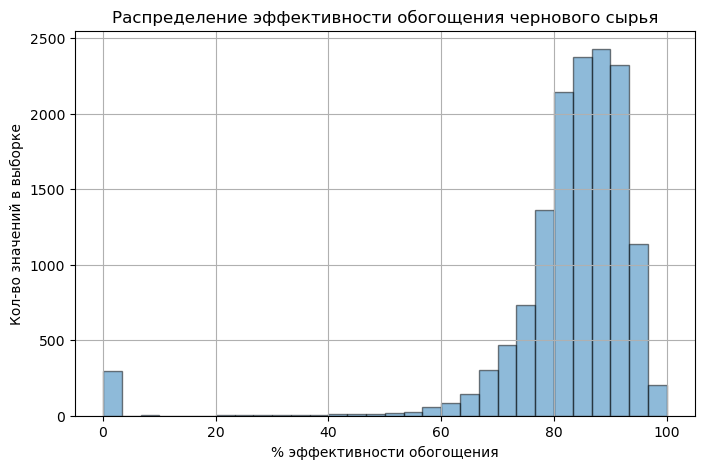

In [133]:
ax = train_mod['rougher.output.recovery'].hist(bins = 30, grid=True, alpha=0.5, edgecolor='black', figsize=(8,5))
ax.set_ylabel('Кол-во значений в выборке')
ax.set_xlabel('% эффективности обогощения')
ax.set_title('Распределение эффективности обогощения чернового сырья')
plt.show()

In [134]:
train_mod['final.output.recovery'].describe()

count    14149.000000
mean        66.518832
std         10.295402
min          0.000000
25%         62.545817
50%         67.432775
75%         72.346428
max        100.000000
Name: final.output.recovery, dtype: float64

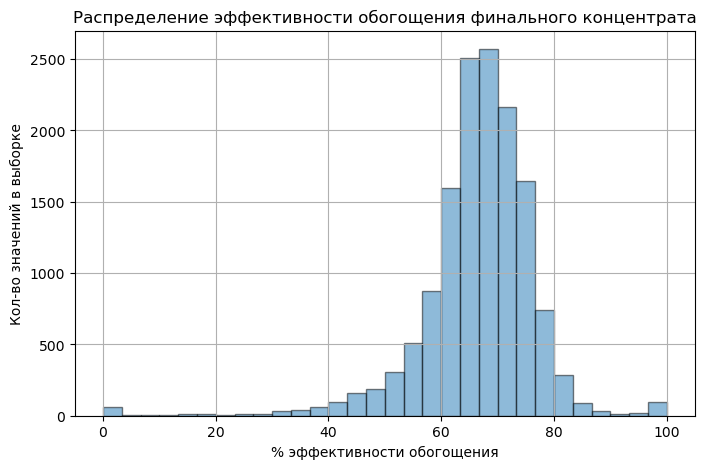

In [135]:
ax = train_mod['final.output.recovery'].hist(bins = 30, grid=True, alpha=0.5, edgecolor='black', figsize=(8,5))
ax.set_ylabel('Кол-во значений в выборке')
ax.set_xlabel('% эффективности обогощения')
ax.set_title('Распределение эффективности обогощения финального концентрата')
plt.show()

Как мы видим распределение целевого признака не соответсвует нормальному, есть сильное смещение вправо в обоих случаях. На гистограмме виден хвост из выбросов. Таким образом, можно сделать вывод - что действительно есть какие-то факторы, в результате которых эффективность обогощения очень низкая.  А в статистических данных мы видим, что есть сырье, чья эффективность обогощения равна 0%.

Чаще всего эффективность обогощения составляет около 90% после этапа флотации и 70% для финального продукта. 

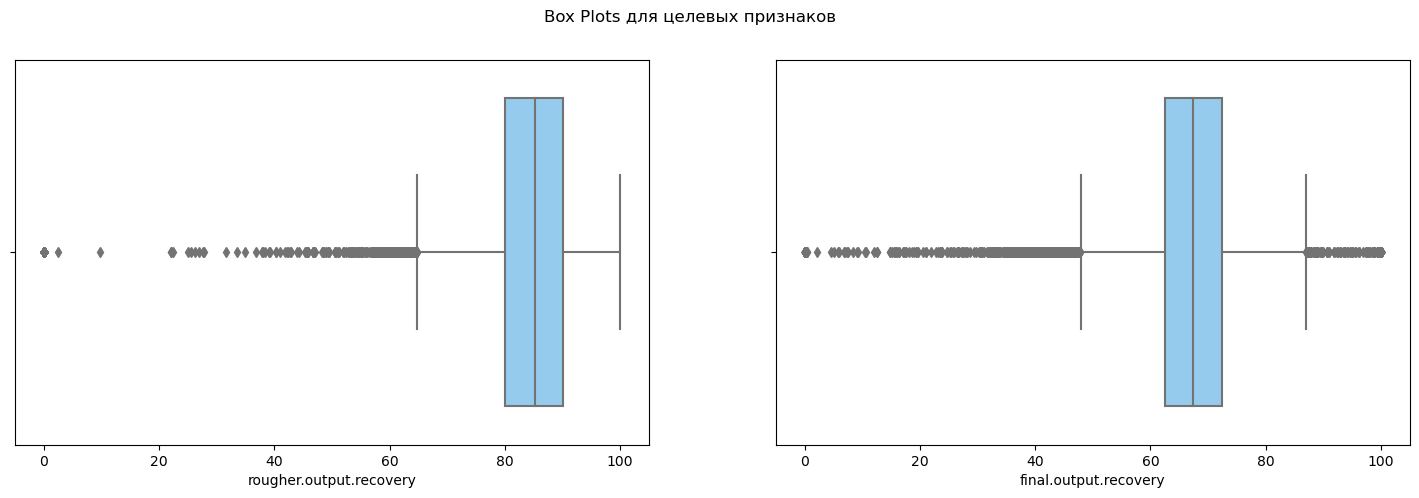

In [136]:
fig, axs = plt.subplots(1, 2, figsize=(18,5)) 
columns = ['rougher.output.recovery', 'final.output.recovery']
for i, col in enumerate(columns):
    sns.boxplot(data=train_mod, x=col, color='#87CEFA', ax=axs[i]) 
fig.suptitle("Box Plots для целевых признаков")
plt.show()

При обогощении чернового концентрата значения ниже 20% встречаются очень редко. При обогощении фнинального концентрата выбросы распределены более равномерно, также выбросом является обогощение выше 90%. Для улучшения качества модели в дальнейшем отфильтруем выборку и избавимся от значений, равных 0.

### Флотация исходного сырья

In [137]:
input_columns = [col for col in train_mod.columns if "rougher.input.feed" in col] 
#отберем этап подачи сырья во флотационную установку

In [138]:
input_columns

['rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au']

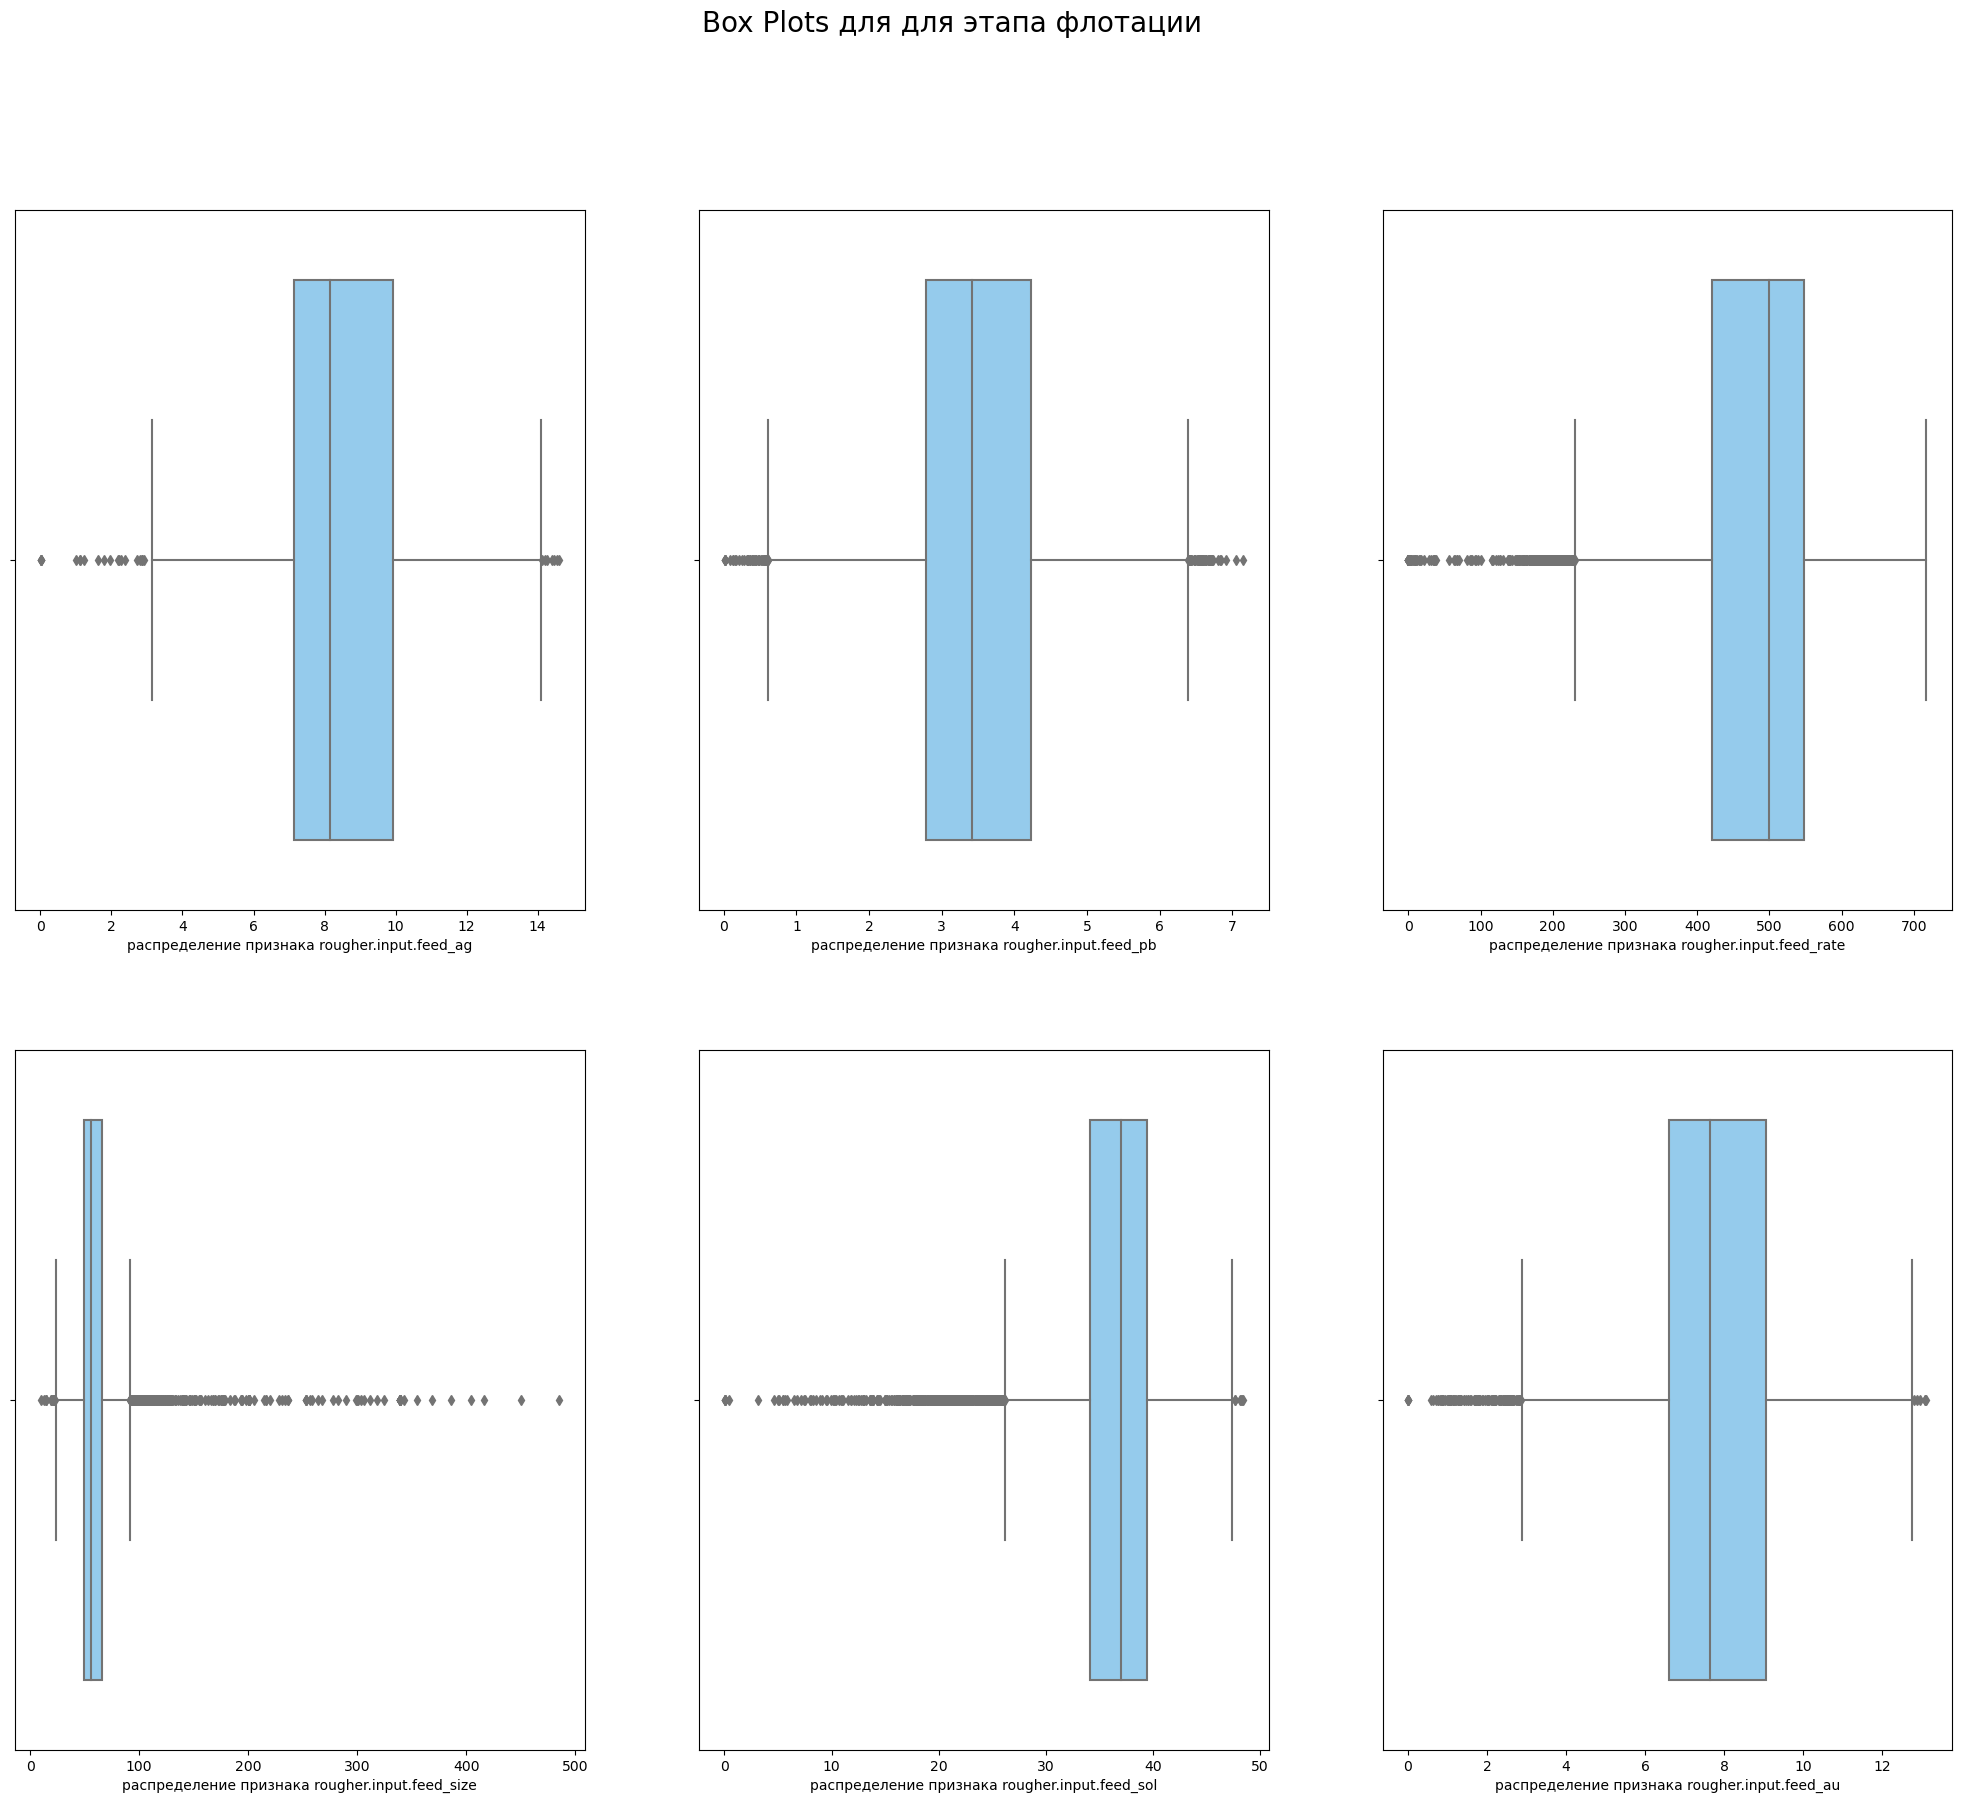

In [139]:
def hist(name, col, rows, cols): #построим функцию, поскольку нужно исследовать несколько стадий
    fig, axs = plt.subplots(rows, cols,figsize=(25,20))
    axs = axs.flatten()
    for i, dt in enumerate(col):
        sns.boxplot(train_mod[dt], ax=axs[i], color='#87CEFA')
        axs[i].set_xlabel(f'распределение признака {dt}')
    fig.suptitle(f"Box Plots для {name}", fontsize=20)        
hist('для этапа флотации',input_columns, rows=2, cols=3)

In [140]:
train_mod[input_columns].describe() #статистика по признакам

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au
count,14149.000000,14049.000000,14141.000000,14005.000000,14071.000000,14149.000000
mean,8.579195,3.522778,474.027714,60.110518,36.312593,7.866577
std,1.896284,1.073394,104.039838,22.418485,4.956057,1.919506
min,0.010000,0.010000,0.012786,9.659576,0.010000,0.010000
25%,7.132802,2.780010,420.781913,48.973027,34.117635,6.596217
50%,8.156092,3.422677,499.454777,55.373885,37.020345,7.649138
75%,9.918304,4.226107,547.334973,66.080172,39.423265,9.066976
max,14.596026,7.142594,717.508837,484.967466,48.363177,13.126043


У всех признаков есть выбивающиеся значения - выбросы, больше всех выбросов у признака размера гранул. Почти у всех признаков есть нулевые значения, есть руда в которой концентрация металлов или солей равна нулю. есть также значение скорости подачи руды в установку равное нулю, что также очень странно и вызывает вопросы об ошибке в данных.

Теперь посмотрим на взаимосвязь признаков:

In [141]:
def heatmap(name, col):
  columns = ["final.output.recovery","rougher.output.recovery"]
  result = columns + col
  plt.figure(figsize = (12, 10))
  sns.heatmap(train_mod[result].phik_matrix(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', linewidths=0.1, linecolor='grey',
            fmt='.1g')
  plt.title(f"Матрица корреляции для {name}")          
  plt.show()

interval columns not set, guessing: ['final.output.recovery', 'rougher.output.recovery', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_rate', 'rougher.input.feed_size', 'rougher.input.feed_sol', 'rougher.input.feed_au']


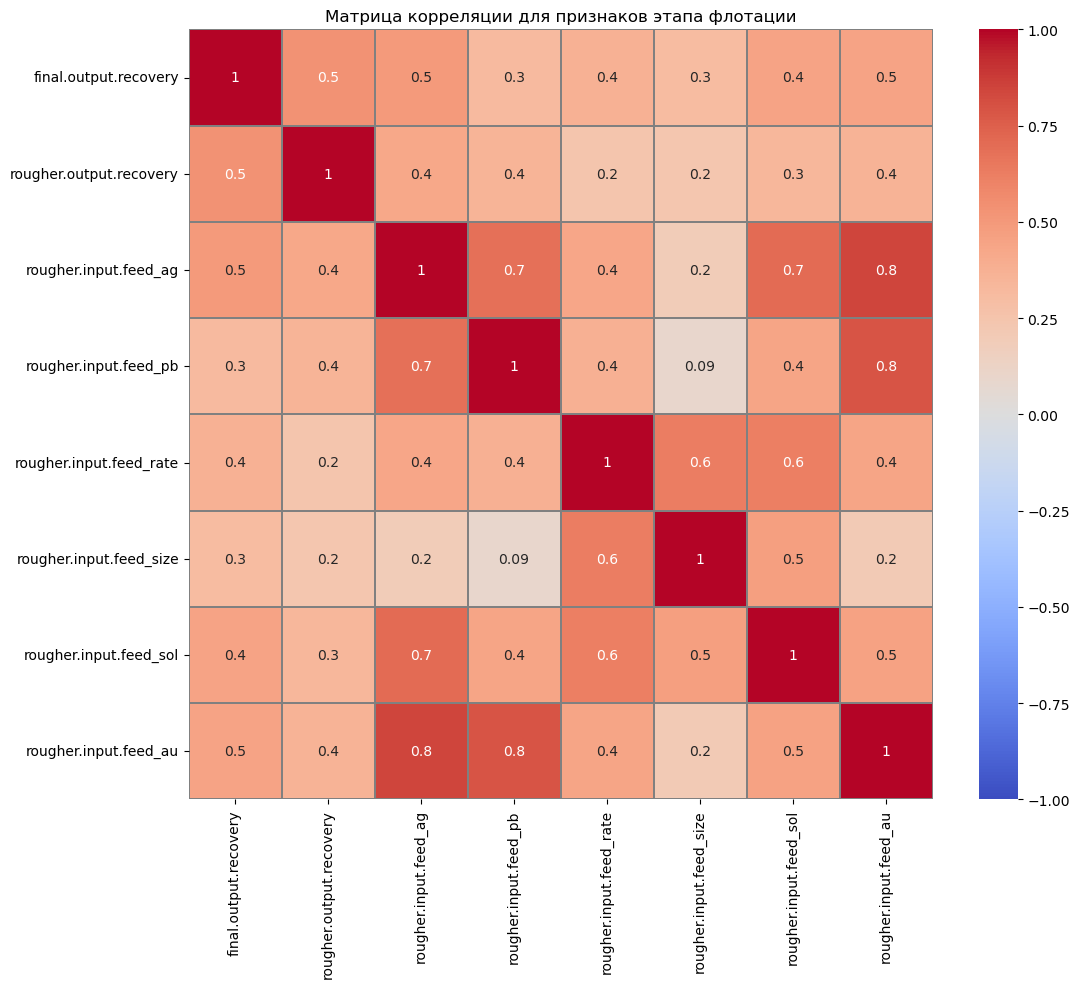

In [142]:
heatmap('признаков этапа флотации', input_columns)

На данной тепловой карте мы можем видеть не только линейную взаимосвязь (корреляцию Пирсона), но и любые другие взаимосвязи. Таким образом, мы можем посмотреть, какие признаки влияют на эффективность обогощения на этапе флотации: мы видим, что от эффективности обогощения сырья зависит и финальная эффективность (к-т 0,5), далее влияет доля золота в исходной руде и скорость подачи сырья в установку, соответсвенно, чем выше эти показатели, тем лучше пройдет обогощение на этапе флотации. Размер гранул тоже влияет, хоть и не так сильно, как скорость. Есть сильная зависимость между содержанием золота и серебра в руде, то есть чем выше концентрация золота в руде (исходном сырье), тем будет выше и концентрация серебра, то же самое можно сказать о свинце. 

### Флотационные установки на этапе флотации

In [143]:
rougher_floatbank_columns = [col for col in train_mod.columns if "rougher.input.floatban" in col or "rougher.state.floatbank" in col] 
#отберем флотационные установки

In [144]:
rougher_floatbank_columns

['rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_level',
 'rougher.state.floatbank10_d_air',
 'rougher.state.floatbank10_d_level',
 'rougher.state.floatbank10_e_air',
 'rougher.state.floatbank10_e_level',
 'rougher.state.floatbank10_f_air',
 'rougher.state.floatbank10_f_level']

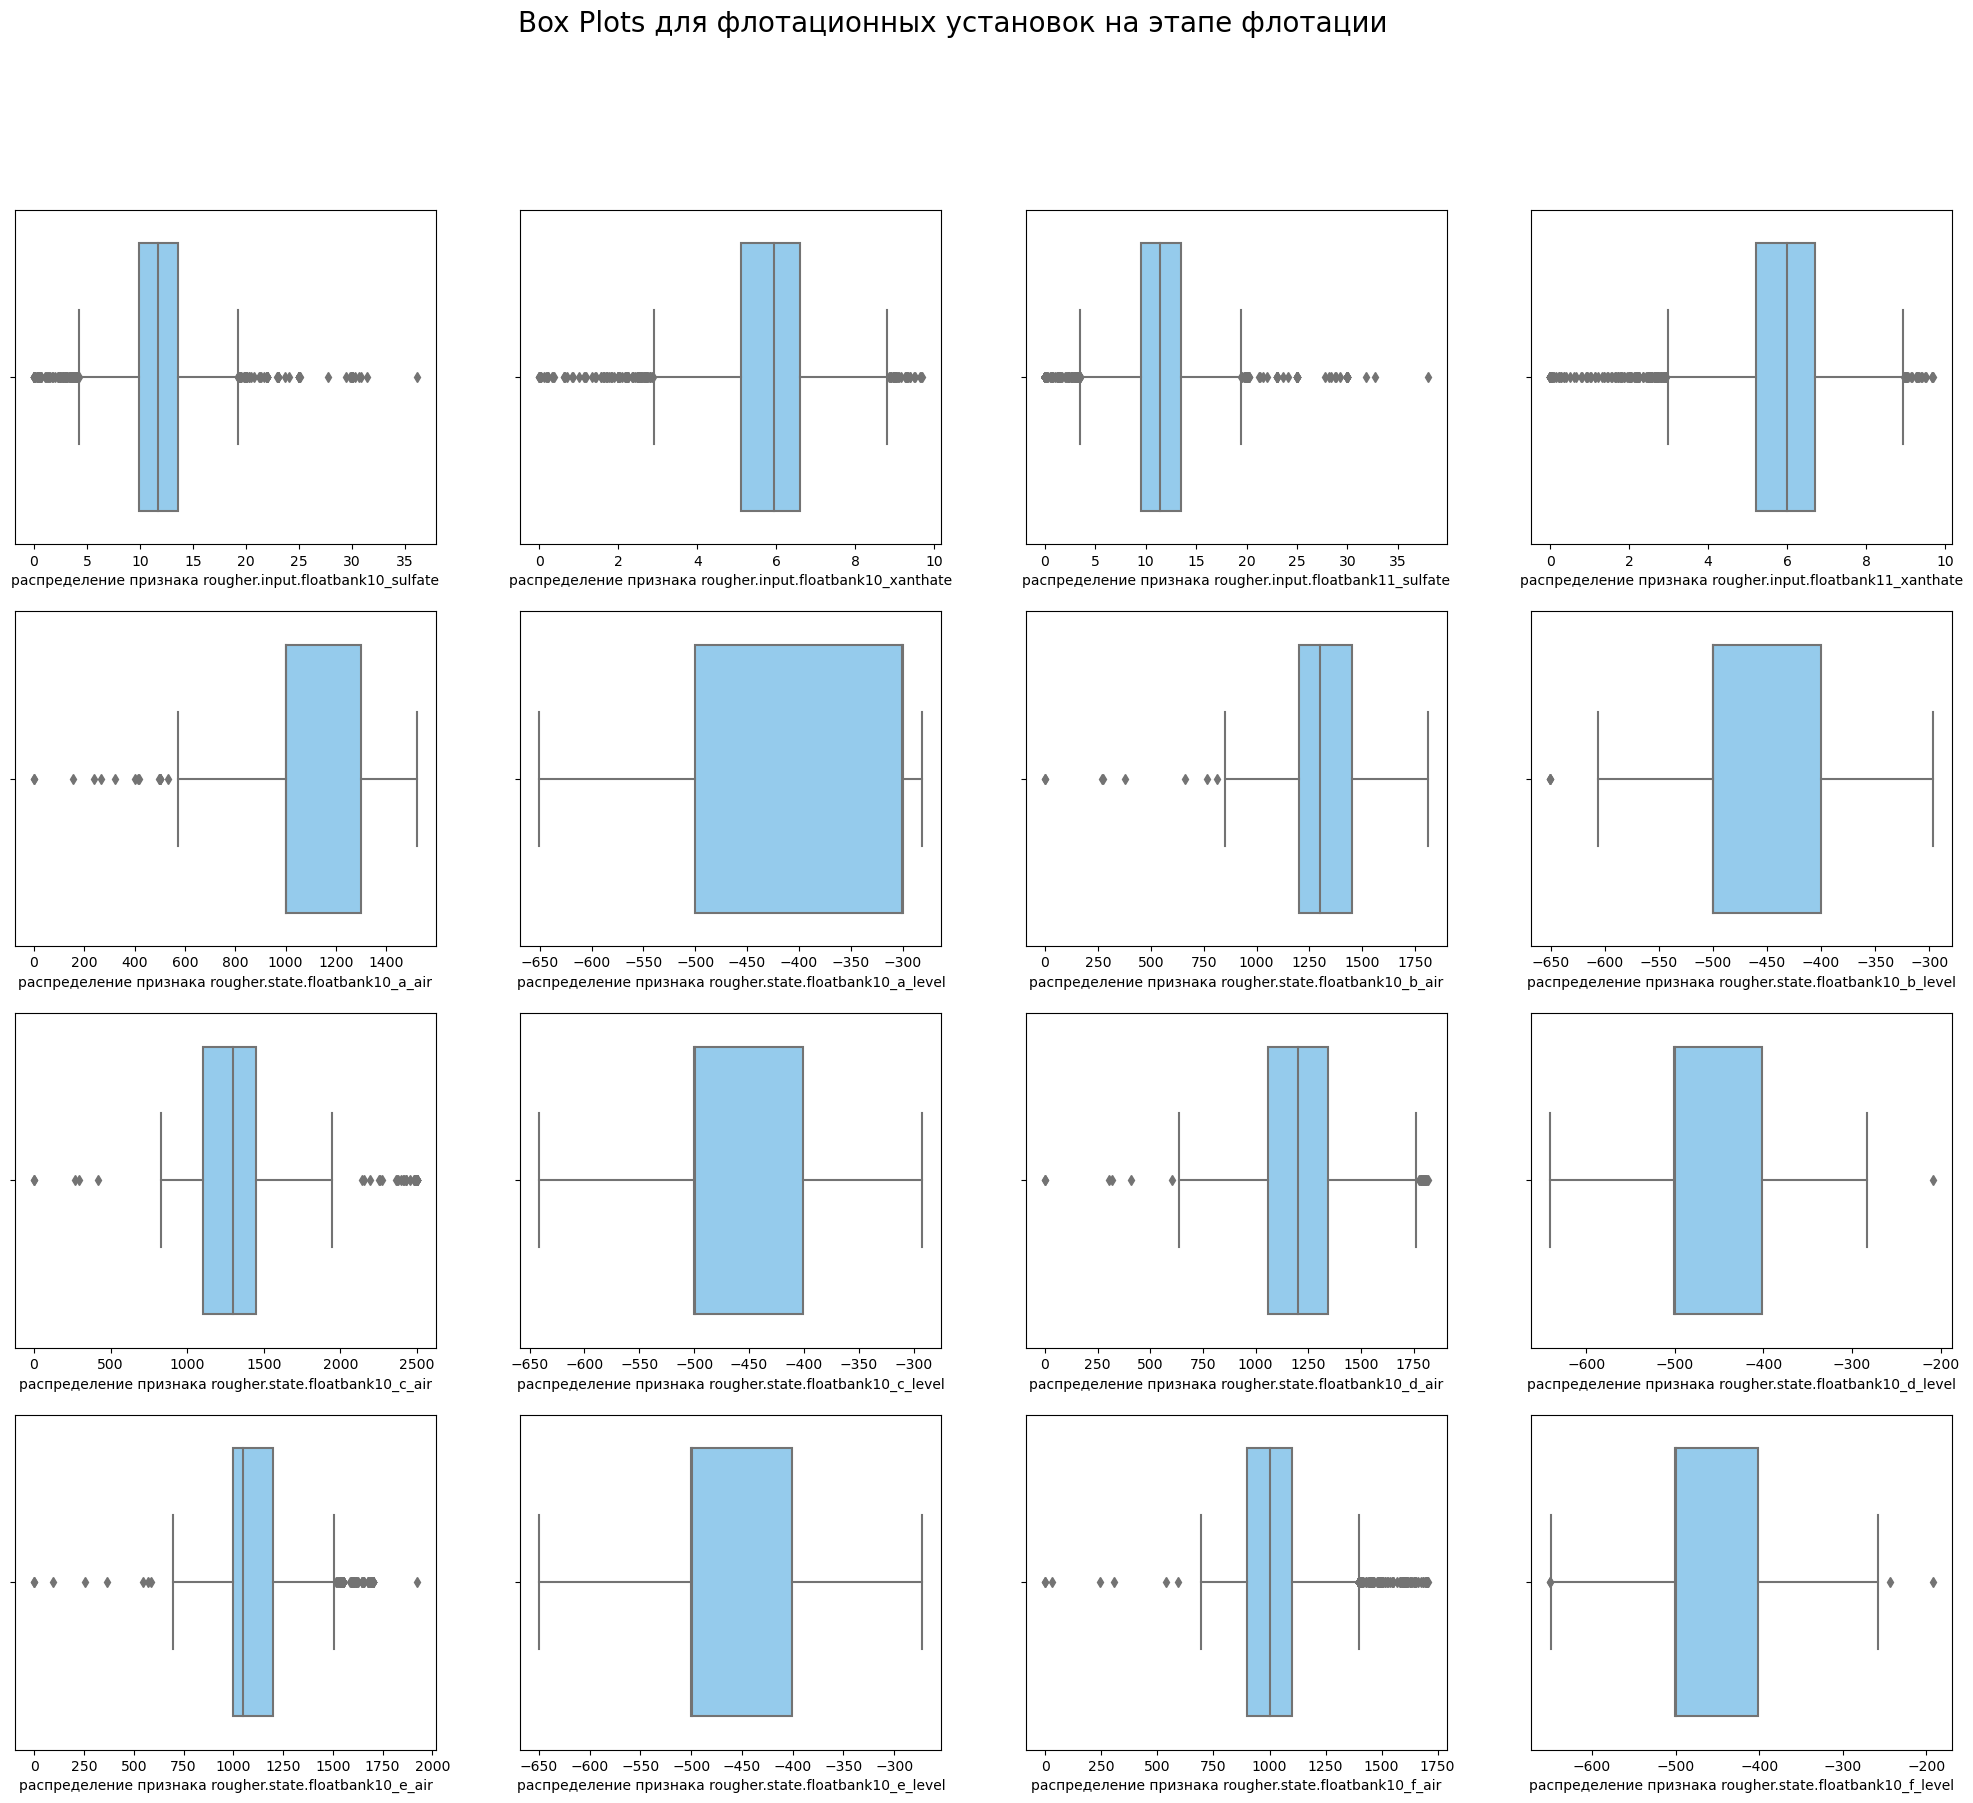

In [145]:
hist('флотационных установок на этапе флотации',rougher_floatbank_columns, rows=4, cols=4)

In [146]:
train_mod[rougher_floatbank_columns].describe() #статистика по признакам

,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
count,14120.000000,14141.000000,14113.000000,13721.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14149.000000,14149.000000,13713.000000,14149.000000,14149.000000,14149.000000
mean,11.764931,5.854529,11.368685,5.894176,1124.726280,-369.460950,1320.705069,-464.258983,1299.360578,-465.054849,1210.335236,-465.457377,1090.213187,-464.919119,1035.490299,-464.688631
std,3.278813,1.104263,3.743672,1.124233,169.310825,93.952787,183.155975,57.401954,213.404094,55.904716,210.431555,55.771393,184.610118,56.602962,175.052279,56.645965
min,0.001083,0.001428,0.000098,0.000290,-0.041078,-650.202881,-0.653384,-650.260008,-0.035112,-640.995627,-0.554299,-640.519003,-1.970275,-649.443911,-2.430587,-649.880981
25%,9.861100,5.117359,9.505507,5.199168,999.799166,-499.787867,1199.366448,-500.183028,1103.095071,-500.211863,1059.708509,-500.359197,997.183864,-500.250033,900.966986,-500.476526
50%,11.688702,5.951071,11.384283,5.998460,1001.685708,-300.175125,1301.365123,-499.764620,1300.213385,-499.682528,1200.744308,-499.465285,1050.496363,-499.611447,1000.053757,-499.364335
75%,13.607115,6.602533,13.497134,6.699006,1299.505513,-299.963153,1449.553689,-400.425493,1450.350668,-400.664736,1344.378462,-401.052891,1200.047746,-400.596104,1100.165435,-401.014951
max,36.118275,9.703448,37.980648,9.698407,1521.980372,-281.039299,1809.194008,-296.383080,2499.129174,-292.155509,1817.199290,-208.330673,1922.636637,-272.199598,1706.307502,-191.718480


На графиках мы видим процесс обработки сырья во флотационных установках. Выбросы в данных есть не на всех этапах обработки, в основном большая часть выбросов сосредоточена на этапе добавления сульфатов и ксантогенатов. Почти у всех признаков есть нулевые значения.

interval columns not set, guessing: ['final.output.recovery', 'rougher.output.recovery', 'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate', 'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air', 'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_f_level']


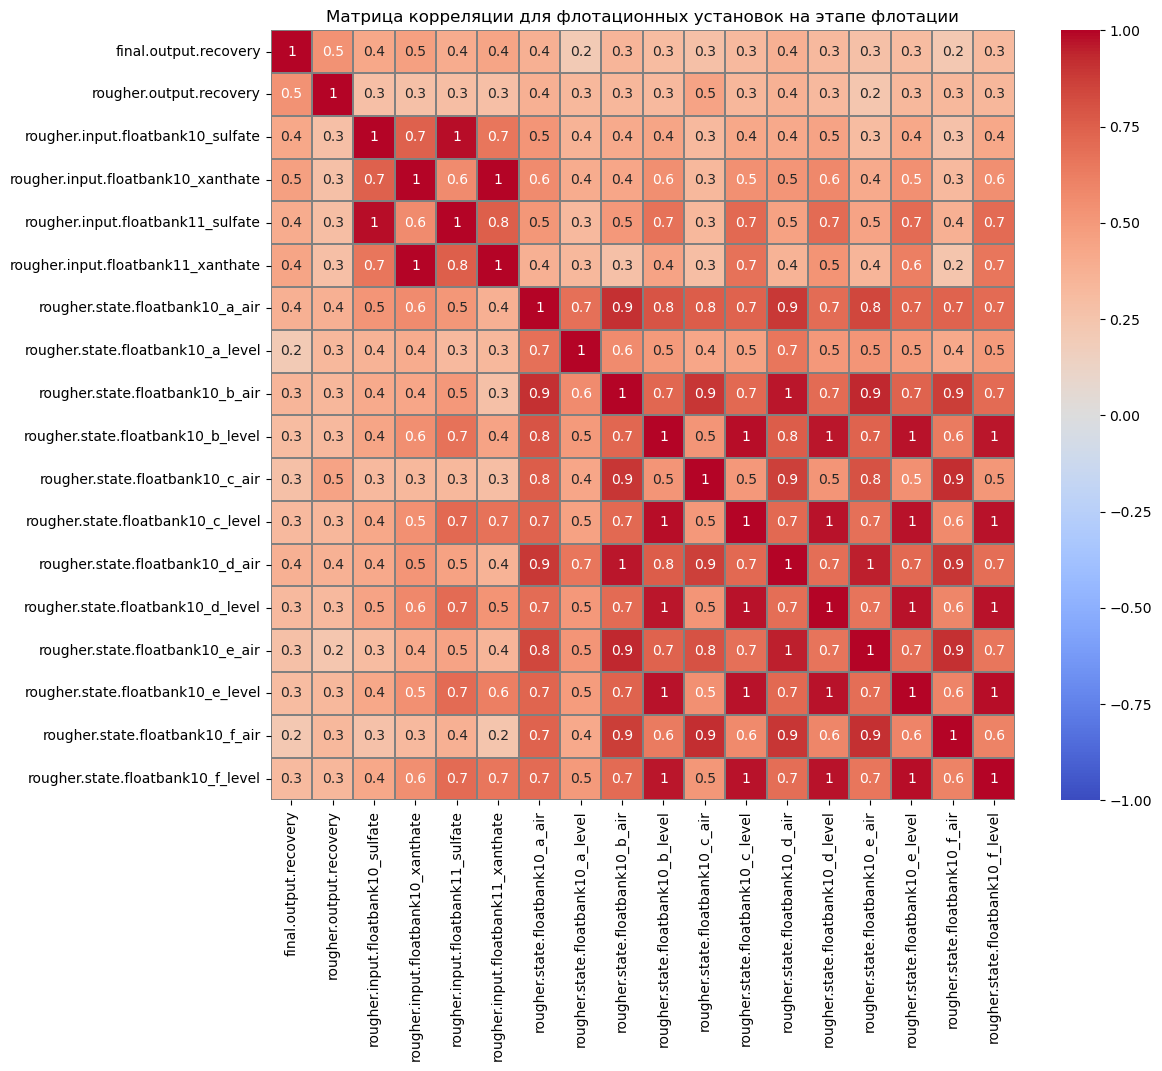

In [147]:
heatmap('флотационных установок на этапе флотации', rougher_floatbank_columns)

### Первичная обработка

In [148]:
primary_cleaner_columns = [col for col in train_mod.columns if "primary_cleaner" in col] #отберем этап первичной обработки

In [149]:
primary_cleaner_columns

['primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level']

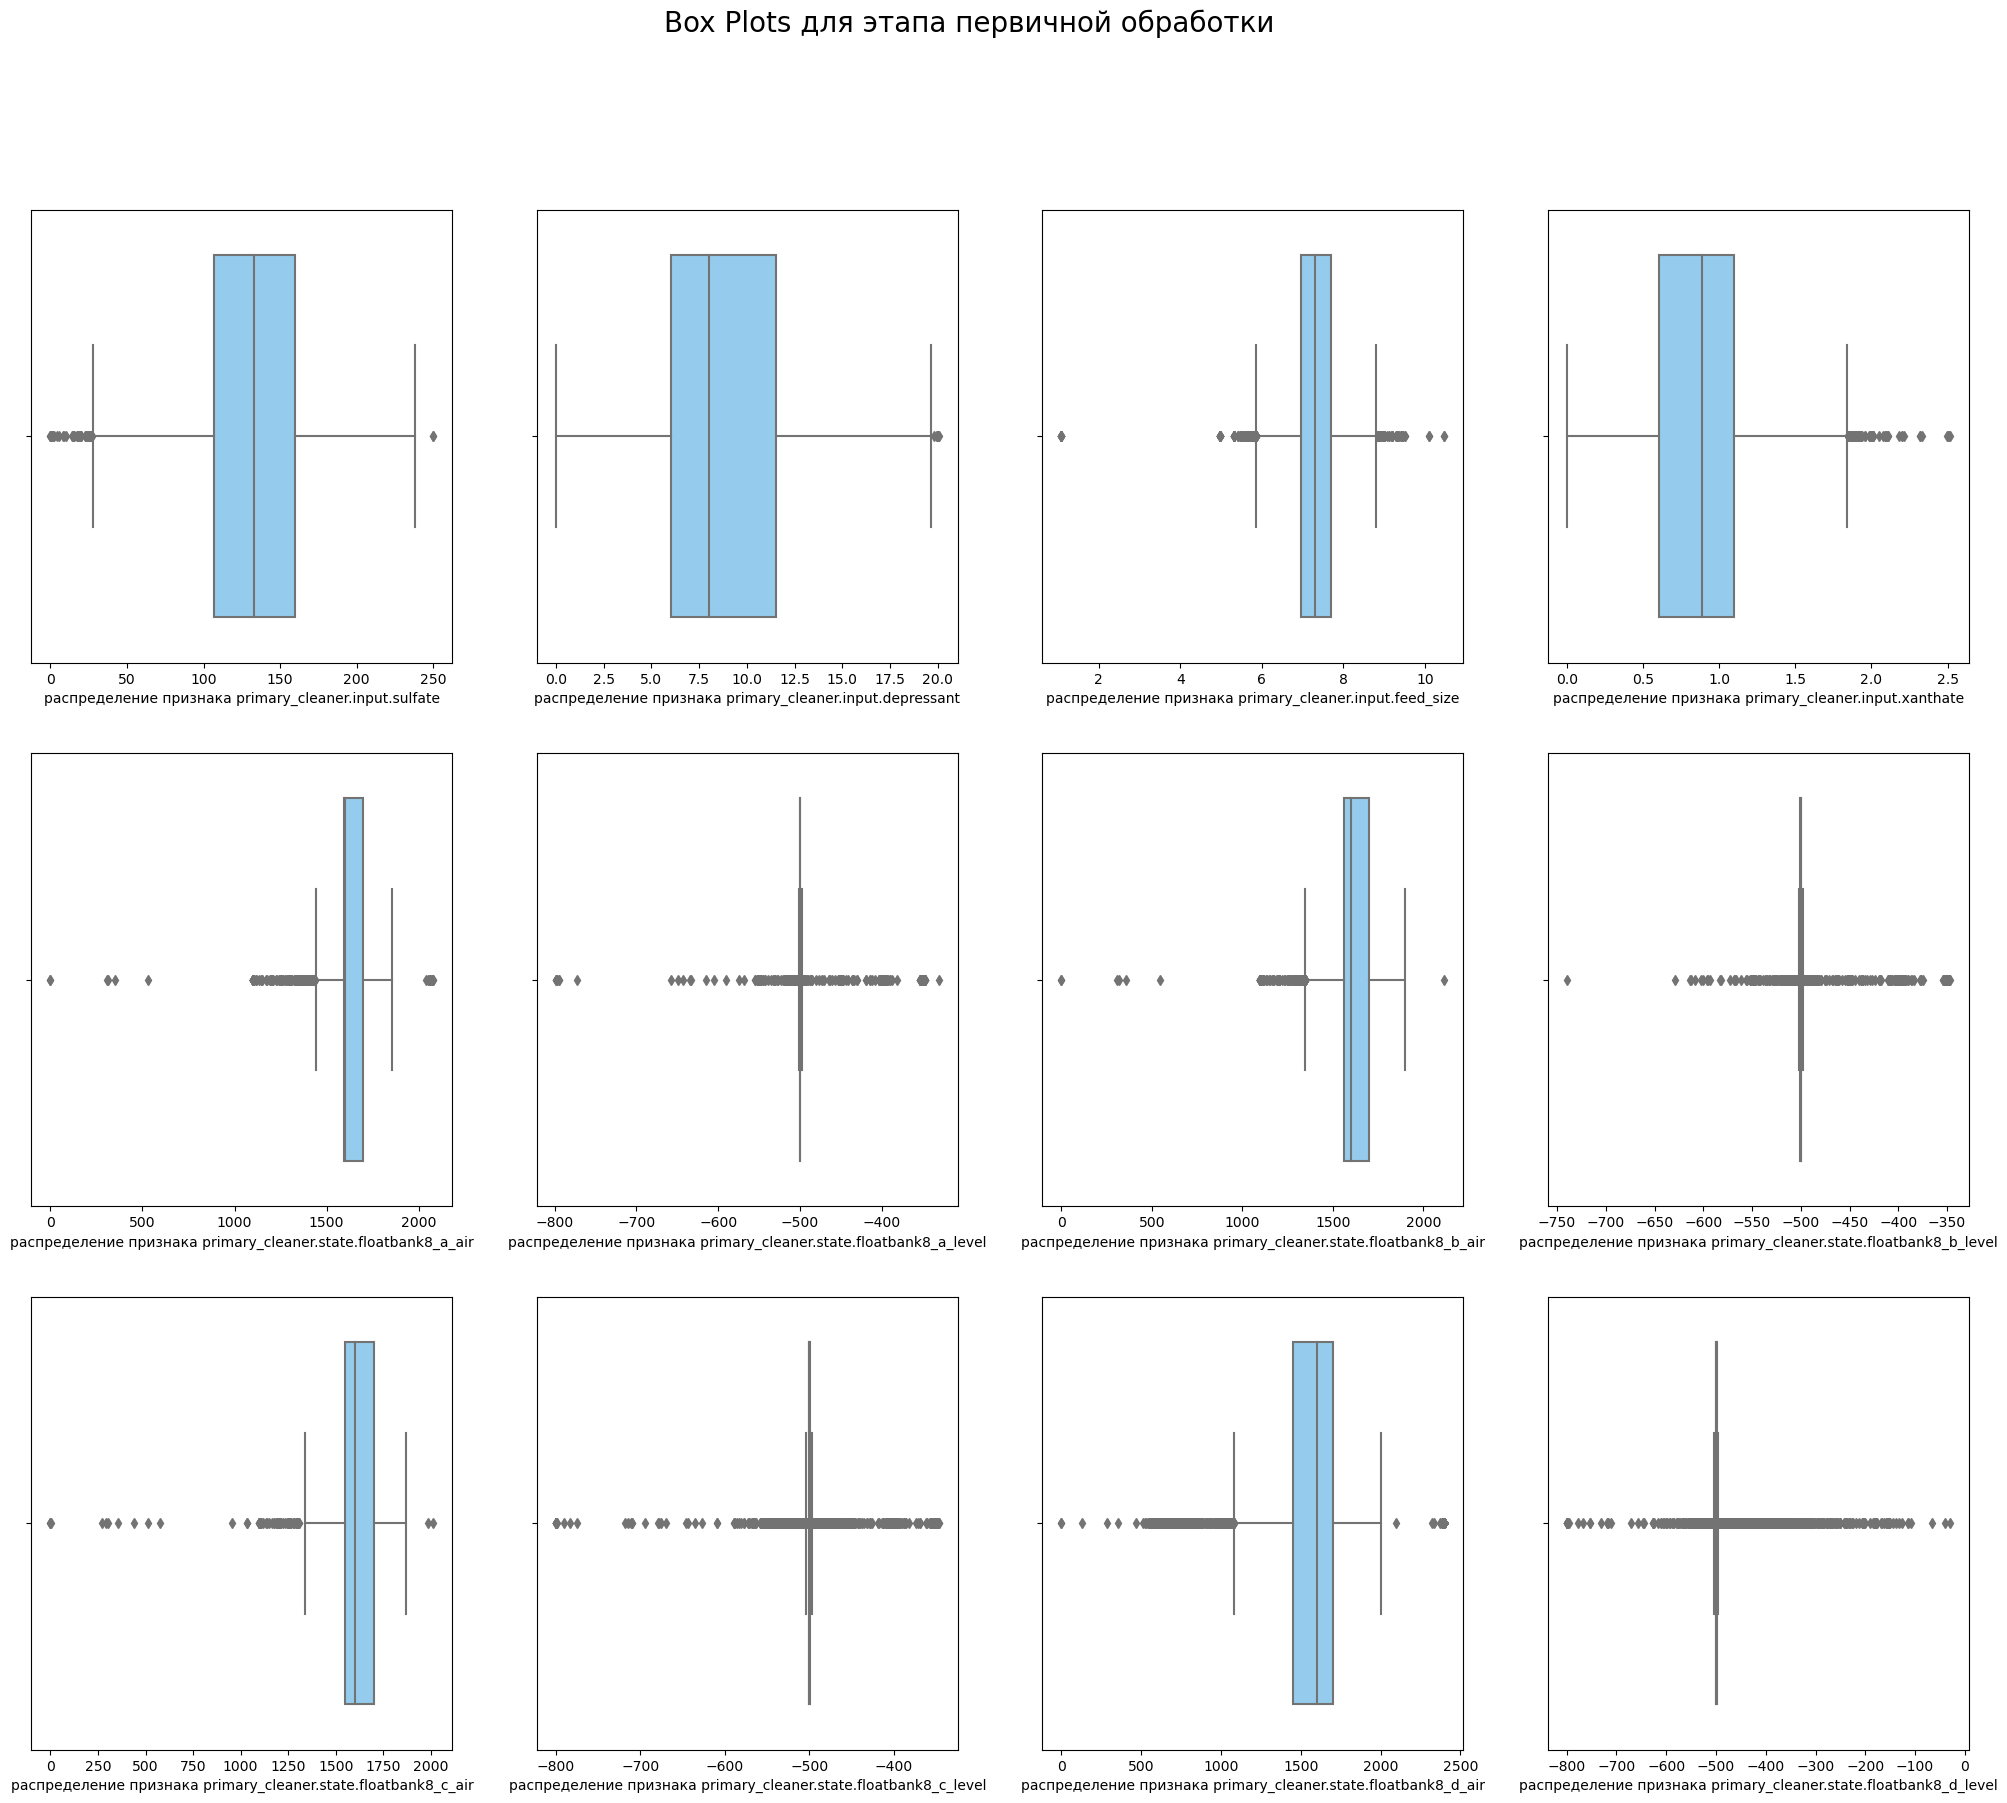

In [150]:
hist('этапа первичной обработки', primary_cleaner_columns, rows=3, cols=4)

In [151]:
train_mod[primary_cleaner_columns].describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level
count,14129.000000,14117.000000,14149.000000,14049.000000,14145.000000,14148.000000,14145.000000,14148.000000,14147.000000,14148.000000,14146.000000,14148.000000
mean,133.320659,8.866996,7.322310,0.885588,1608.000064,-488.775525,1608.610983,-489.171786,1608.879407,-489.605549,1542.189963,-483.462423
std,39.431659,3.361589,0.614062,0.372714,128.394355,35.704184,131.112729,33.604449,134.266898,35.624002,278.316132,47.100934
min,0.003112,0.000000,1.080000,0.000005,0.006352,-798.641662,0.008700,-740.122129,0.015159,-799.803073,0.008655,-799.788598
25%,107.006651,6.040604,6.960000,0.607021,1595.695815,-500.287952,1558.959943,-500.375645,1549.871886,-500.601718,1452.678767,-500.459917
50%,133.018328,8.035811,7.290000,0.888749,1601.824410,-499.909375,1601.818514,-499.938003,1601.574628,-499.871346,1600.168346,-499.831833
75%,159.825396,11.522173,7.700000,1.100933,1699.716408,-499.378551,1700.215351,-499.389658,1700.464037,-498.801774,1699.358771,-498.480341
max,250.127834,20.052255,10.470000,2.512968,2079.531340,-330.134203,2114.906758,-347.354380,2013.156457,-346.653450,2398.903635,-30.601828


На этапе первичной обработки, в отличии от этапа флотации, напротив очень много признаков с явными выбросами, для некоторых установок разброс в данных очень большой.И опять такие признаки как конц-я деприсантов, сульфатов и ксантогенатов имеют нулевые значения. 

interval columns not set, guessing: ['final.output.recovery', 'rougher.output.recovery', 'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate', 'primary_cleaner.state.floatbank8_a_air', 'primary_cleaner.state.floatbank8_a_level', 'primary_cleaner.state.floatbank8_b_air', 'primary_cleaner.state.floatbank8_b_level', 'primary_cleaner.state.floatbank8_c_air', 'primary_cleaner.state.floatbank8_c_level', 'primary_cleaner.state.floatbank8_d_air', 'primary_cleaner.state.floatbank8_d_level']


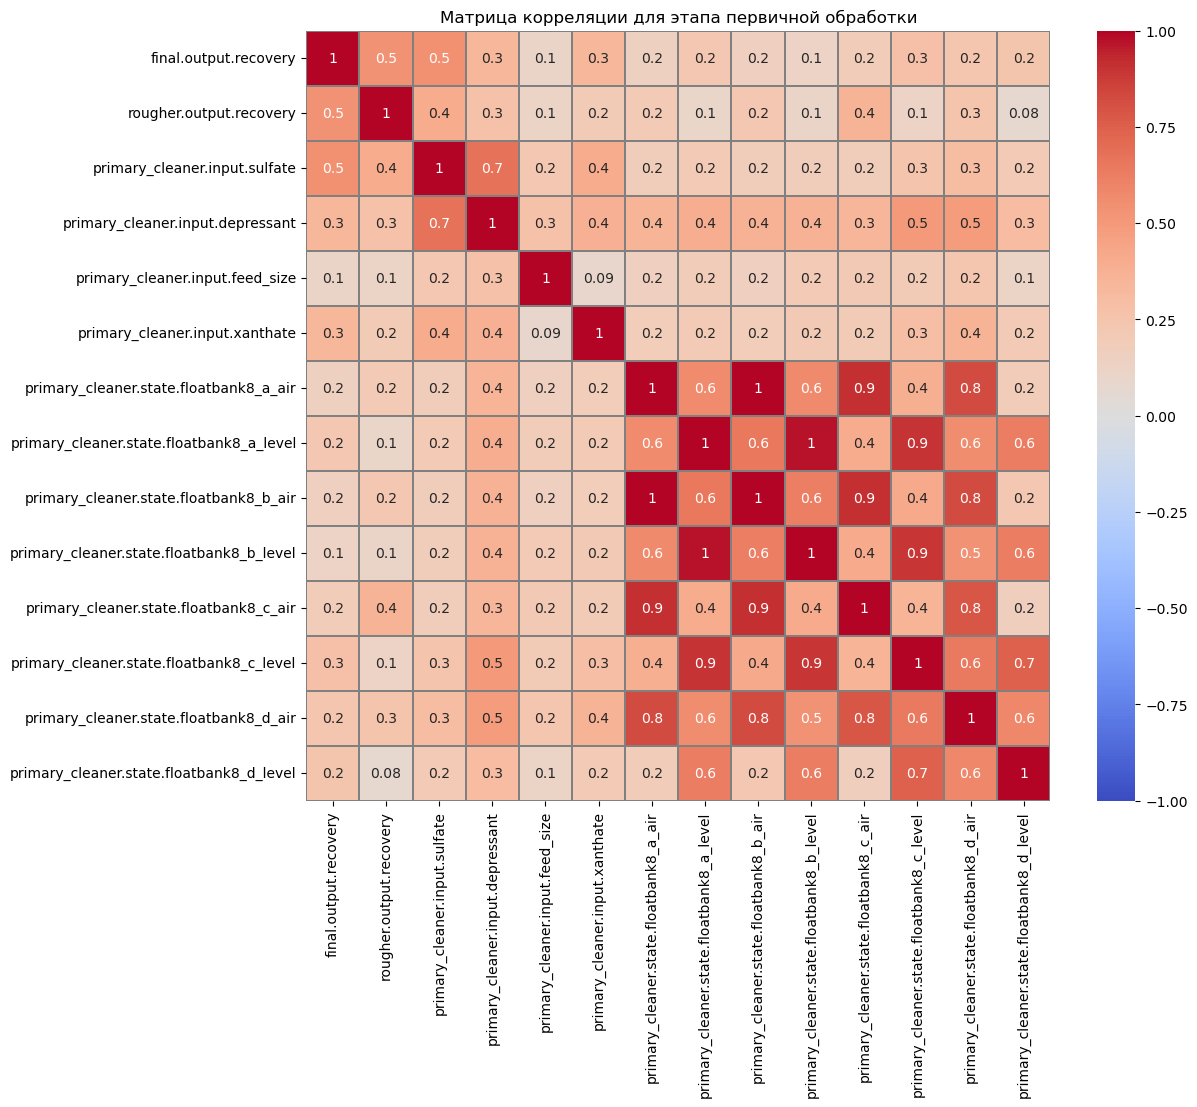

In [152]:
heatmap('этапа первичной обработки', primary_cleaner_columns)

Есть взаимосвязь между подачей сульфатов, деприсантов и ксантогенатов на первом этапе очистки и эффективностью финального обогощения. На этом этапе на второй целевой признак смотреть не имеет смысла, так как все действия происходят уже после флотации. Также между установками 8А и 8В очень сильная взаимосвязь (мультиколленеарность). 

### Вторичная обработка

In [153]:
secondary_cleaner_columns = [col for col in train_mod.columns if "secondary_cleaner" in col] #отберем этап вторичной обработки

In [154]:
secondary_cleaner_columns

['secondary_cleaner.state.floatbank2_a_air',
 'secondary_cleaner.state.floatbank2_a_level',
 'secondary_cleaner.state.floatbank2_b_air',
 'secondary_cleaner.state.floatbank2_b_level',
 'secondary_cleaner.state.floatbank3_a_air',
 'secondary_cleaner.state.floatbank3_a_level',
 'secondary_cleaner.state.floatbank3_b_air',
 'secondary_cleaner.state.floatbank3_b_level',
 'secondary_cleaner.state.floatbank4_a_air',
 'secondary_cleaner.state.floatbank4_a_level',
 'secondary_cleaner.state.floatbank4_b_air',
 'secondary_cleaner.state.floatbank4_b_level',
 'secondary_cleaner.state.floatbank5_a_air',
 'secondary_cleaner.state.floatbank5_a_level',
 'secondary_cleaner.state.floatbank5_b_air',
 'secondary_cleaner.state.floatbank5_b_level',
 'secondary_cleaner.state.floatbank6_a_air',
 'secondary_cleaner.state.floatbank6_a_level']

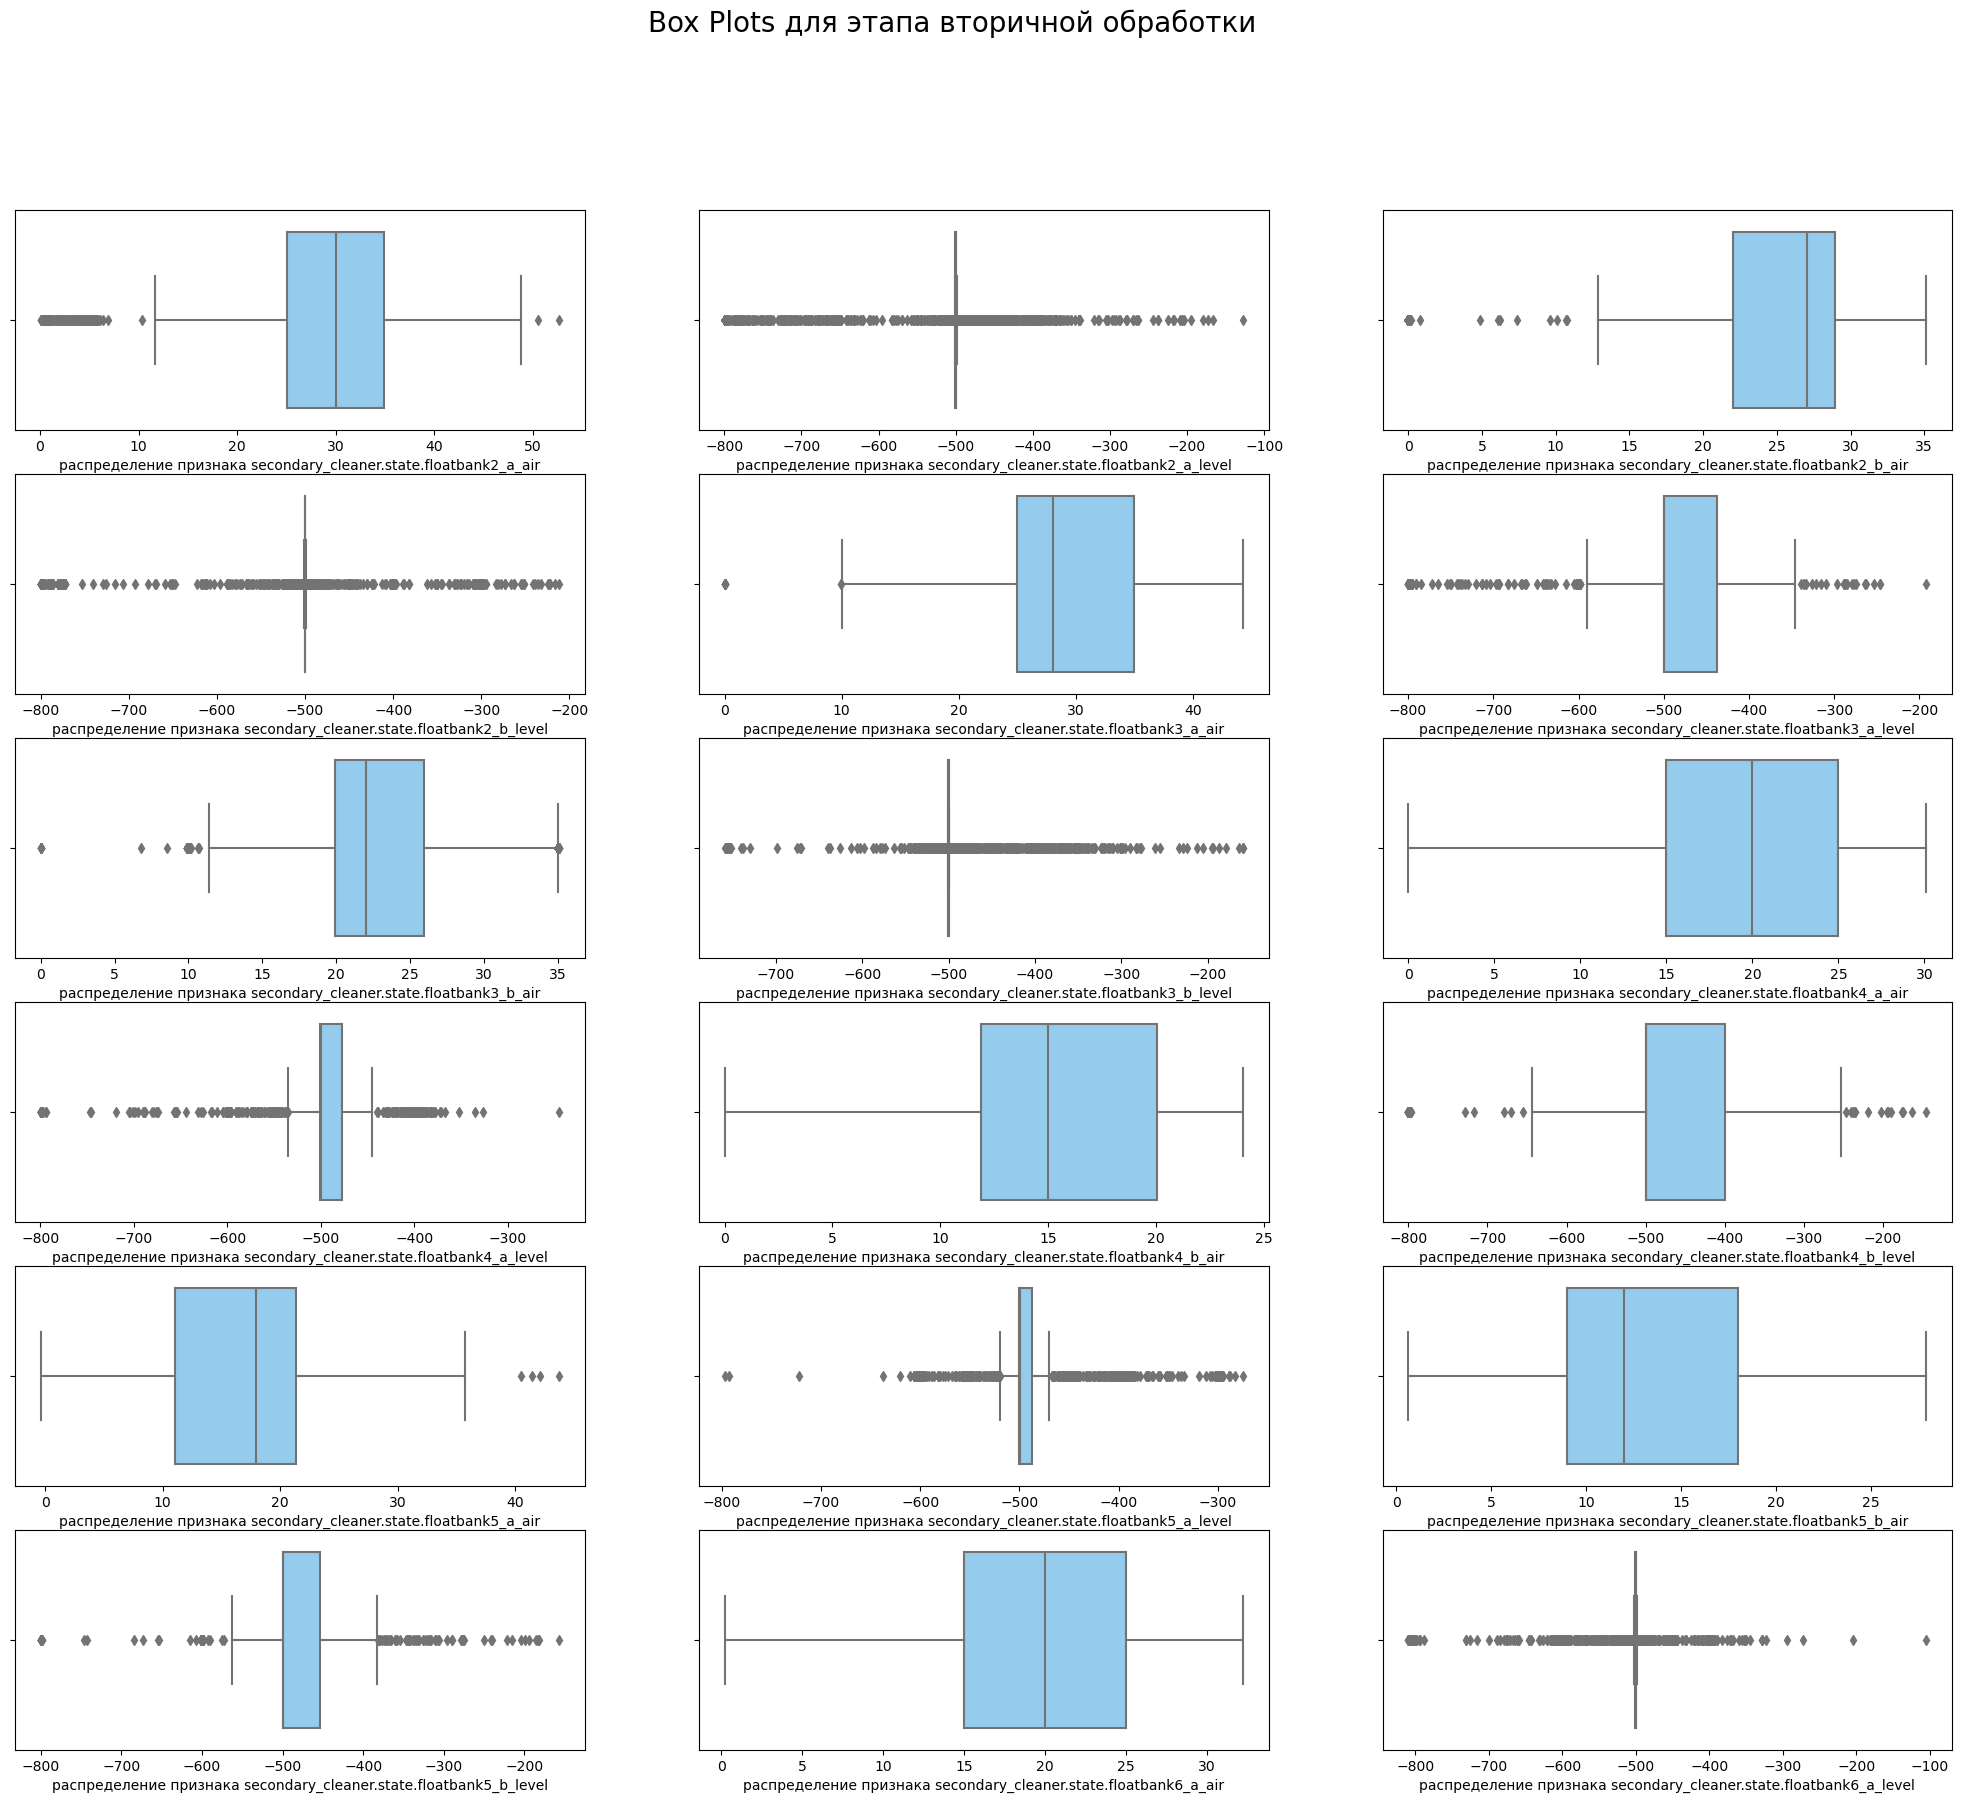

In [155]:
hist('этапа вторичной обработки', secondary_cleaner_columns, rows=6, cols=3)

In [156]:
train_mod[secondary_cleaner_columns].describe()

,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,13932.000000,14148.000000,14128.000000,14148.000000,14145.000000,14148.000000,14148.000000,14148.000000,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,29.613649,-502.223914,24.914403,-503.695706,29.243372,-478.244059,22.656261,-488.924046,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,5.800494,60.281705,5.994959,62.837357,5.637309,54.655143,4.996017,41.928112,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.077503,-799.606441,0.000000,-799.873878,0.000000,-799.613013,0.000000,-759.177381,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,25.099584,-500.248814,22.048294,-500.270997,24.991662,-500.175065,19.948436,-500.110581,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,30.027721,-499.959206,27.022783,-500.014092,28.016530,-499.877837,22.037270,-499.966809,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,34.893057,-499.593198,28.939454,-499.764112,34.990095,-436.923166,25.970365,-499.757501,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,52.651399,-127.875565,35.152122,-212.064665,44.260464,-191.678810,35.072841,-159.742331,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


Данные графики описывают уровень жидкости и объем воздуха во флотационных установках на этапе вторичной очистки сырья. Есть довольно стабильные и предсказуемые признаки, для нет выбросов и наоборост, есть признаки, для которых значения всегда разные - и для них межквартильный размах почти отсутствует.

interval columns not set, guessing: ['final.output.recovery', 'rougher.output.recovery', 'secondary_cleaner.state.floatbank2_a_air', 'secondary_cleaner.state.floatbank2_a_level', 'secondary_cleaner.state.floatbank2_b_air', 'secondary_cleaner.state.floatbank2_b_level', 'secondary_cleaner.state.floatbank3_a_air', 'secondary_cleaner.state.floatbank3_a_level', 'secondary_cleaner.state.floatbank3_b_air', 'secondary_cleaner.state.floatbank3_b_level', 'secondary_cleaner.state.floatbank4_a_air', 'secondary_cleaner.state.floatbank4_a_level', 'secondary_cleaner.state.floatbank4_b_air', 'secondary_cleaner.state.floatbank4_b_level', 'secondary_cleaner.state.floatbank5_a_air', 'secondary_cleaner.state.floatbank5_a_level', 'secondary_cleaner.state.floatbank5_b_air', 'secondary_cleaner.state.floatbank5_b_level', 'secondary_cleaner.state.floatbank6_a_air', 'secondary_cleaner.state.floatbank6_a_level']


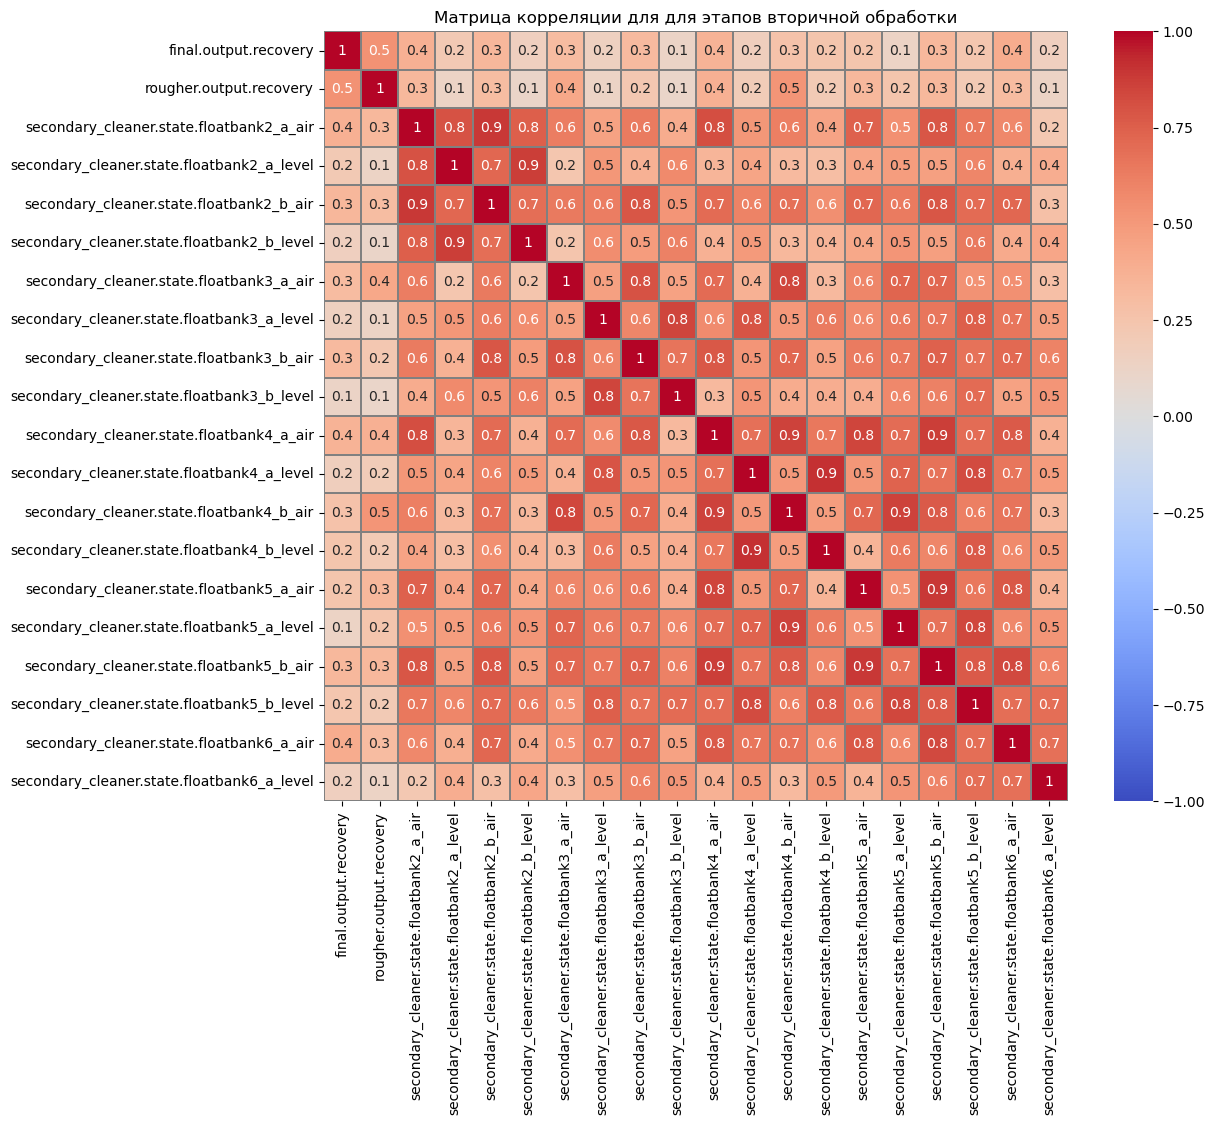

In [157]:
heatmap('для этапов вторичной обработки',secondary_cleaner_columns)

Несмотря на сходство процесса, к-ты равные 1 отсутсвуют, но взаимосвязь между собой у признаков очень высокая. Можно отметить, что объем воздуха в установке имеет большее значение, чем уровень жидкости для эффективности обогощения финального продукта. 

**Промежуточный вывод:** Рассмотрена часть цикла очистки золотой руды, доступная для построения прототипа. Выявлены связи вмежду содержания цветных металлов в руде и повышением эффективности обогощения на каждом из этапов, то есть, чем выше доля золота в руде, тем выше эффективность обогощения на всех этапах, также к увелечению эффективности обогощения ведет увеличение скорости подачи руды во флотационную установку и увеличение концентрации ксантогенатов и сульфатов на всех стадиях очистки. Также обнаружено множество признаков с нулевыми значениями, которые возможно стоит удалить для улучшения качества модели.

## Предобработка данных

### Пропуски и стандартизация

Оценим, сколько значений в процентном соотношении пропущено в рабочем датасете train_mod (признаки полностью совпадают с выборкой test):

In [158]:
train_mod.isna().mean().sort_values(ascending=False)*100 

rougher.state.floatbank10_e_air               3.081490
rougher.input.floatbank11_xanthate            3.024949
secondary_cleaner.state.floatbank2_a_air      1.533677
rougher.input.feed_size                       1.017740
rougher.input.feed_pb                         0.706764
primary_cleaner.input.xanthate                0.706764
rougher.input.feed_sol                        0.551276
rougher.input.floatbank11_sulfate             0.254435
primary_cleaner.input.depressant              0.226164
rougher.input.floatbank10_sulfate             0.204961
secondary_cleaner.state.floatbank2_b_air      0.148420
primary_cleaner.input.sulfate                 0.141353
rougher.input.floatbank10_xanthate            0.056541
rougher.input.feed_rate                       0.056541
secondary_cleaner.state.floatbank4_a_air      0.042406
primary_cleaner.state.floatbank8_b_air        0.028271
primary_cleaner.state.floatbank8_a_air        0.028271
secondary_cleaner.state.floatbank3_a_air      0.028271
primary_cl

Пропущено данных от 3% и меньше, но пропуски есть почти в каждом столбце. В целевых признаках пропусков нет. Удалять данные не будем, хотя количество пропусков не критично и менее 10%. Попробуем заполнить пропуски методом **IterativeImputer**. Он обучает регрессионную модель для каждой функции, чтобы предсказать недостающие значения на основе всех других доступных функций.Затем он снова обучает модель на обновленных данных и повторяет процесс несколько раз, улучшая модели и значения замены на каждой итерации.

Cделаем это на этапе моделирования в контейнере pipeline, там же стандартизируем все признаки оценщиком StandardScaler. На этапе предобработки создадим необходимый нам конвейр трансформации:

In [159]:
pipeline_data = make_pipeline(IterativeImputer(), # заполняем пропуски
                         StandardScaler()) #масштабируем данные

## Вывод по производственному процессу



1. Загружены три датасета с данными, из них train будет использован в качестве обучающего, на test будет проводится тестирование.
2. Тестовая и обучающая выборки приведены к единому размеру - для тестовой восстановлены целевые признаки, для обучающей исключены признаки, которых нет в тестовом наборе данных.
3. Рассмотрена и проанализирована чать данных с производственного процесса, доступных для построения прототипа. Выявлены нулевые значения для некоторых признаков.
4. Выявлены пропуски в данных, принято решение запольнить их с помощью IterativeImputer.



# Анализ данных

## Kонцентрация металлов (Au, Ag, Pb) на различных этапах очистки.

In [160]:
def concentrate(name):
    columns = ['rougher.input.feed_'+name, 'rougher.output.concentrate_'+name, 
            'primary_cleaner.output.concentrate_'+name, 'final.output.concentrate_'+name]
    fig1, ax1 = plt.subplots(figsize=(12, 8)) 
    for col in columns:
      sns.kdeplot(train[col], shade=True, alpha=.5, ax=ax1, label=col)
      sns.despine(left=True, bottom=True)
      plt.grid(linewidth=0.5, color="gray", linestyle="--")
      plt.xlabel("конц-я сырья")
      plt.legend()
      plt.title('Концентрация металла ' + str(name).title() + ' на различных этапах очистки', fontsize=12)


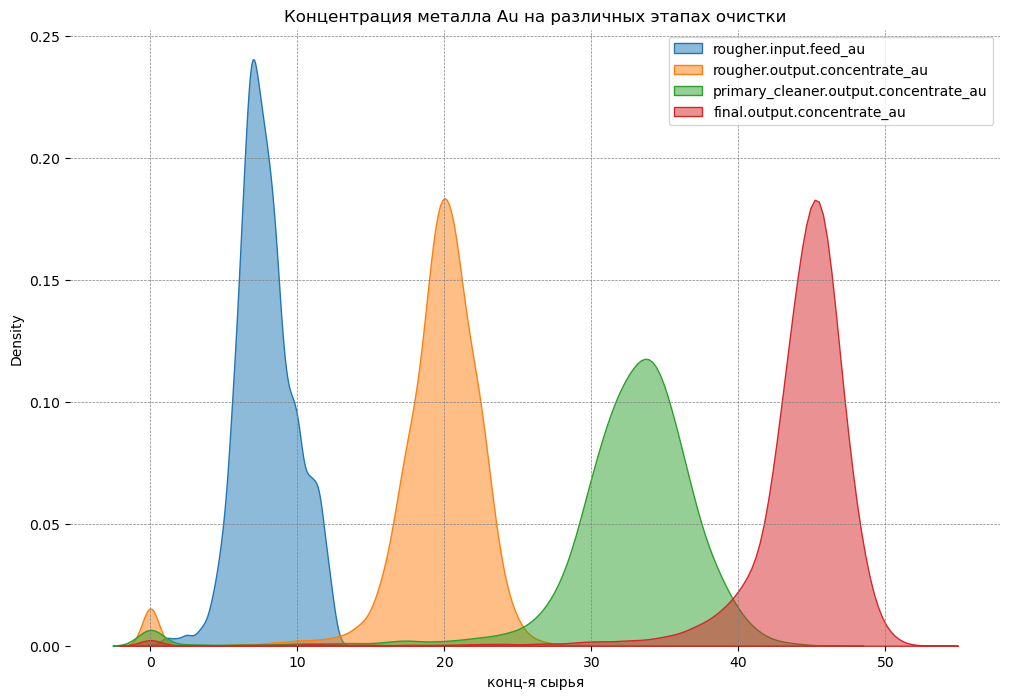

In [161]:
concentrate('au')

Концентрация золота повышается с каждым этапом очистки, при этом с каждым последующим этапом увеличиваются выбросы. Есть сырье для которого на финальном этапе очистки концентрация золота равна нулю.

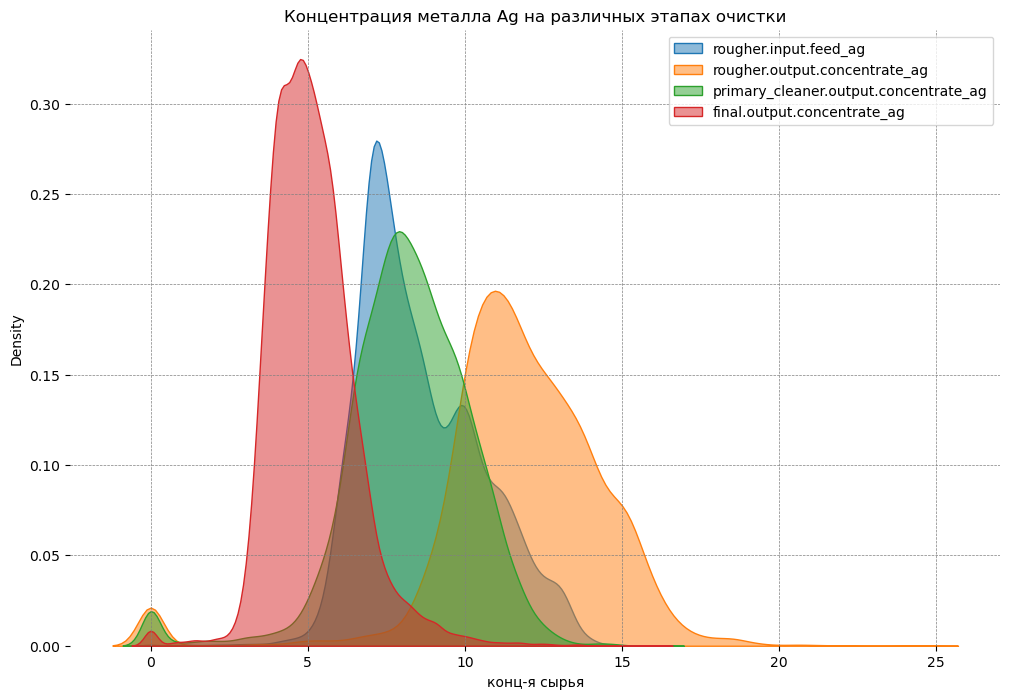

In [162]:
concentrate('ag')

Концентрация серебра увеличивалась до первого этапа очистки, после первого этапа резко сократилась и в финальном продукте содержание этого металла самое низкое.

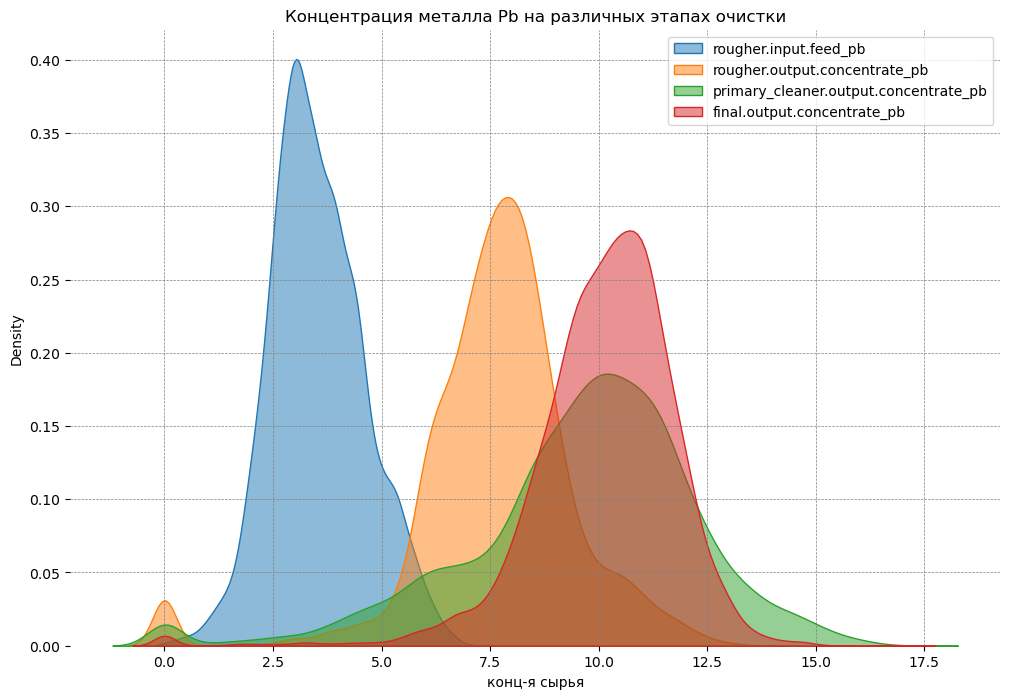

In [163]:
concentrate('pb')

Конц-я свинца росла до финального обогощения, в финальном продукте концентрация свинца почти такая же, как после первичной очистки.

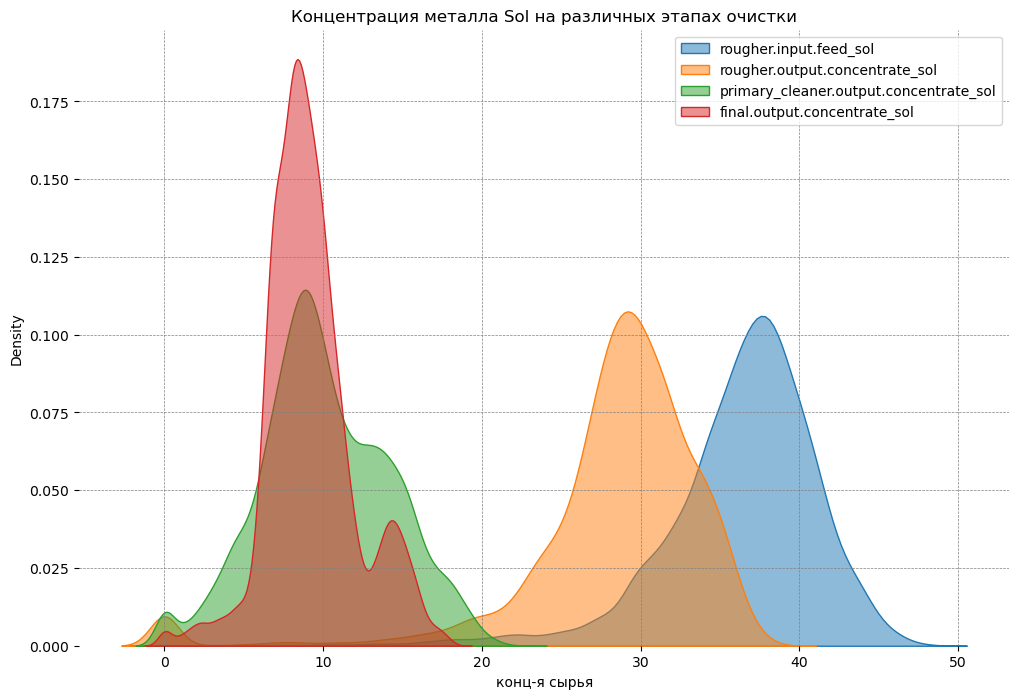

In [164]:
concentrate('sol')

Концентрация солей самая низкая в финальном продукте

На графиках хорошо видно, как менялась концентрация металлов на разных этапах обогощения сырья. Так в исходном сырье самая высокая концентрация солей, от которых нужно сырье очистить, концентрация серебра и золота примерно одинаковая. После флотации исходного сырья часть солей уходит в хвосты, концентрация золота резко повышается. После первичной очистки и на финальном этапе в составе продукта в основном золото, концентрация серебра уменьшилась приблизительно в два раза от содержания в руде, незначительно выросла концентрация свинца, концентрация солей уменьшилась значительно.

## Pаспределения размеров гранул сырья

Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

In [165]:
train_mod['is_data'] = 'train' #cоздадим дополнительные колонки, которые нам понадобятся для построения графиков, после анализа просто их удалим
test['is_data'] = 'test'
# мы используем выборку train_mod, так как она по количеству колонок совпадает с test

In [166]:
random_train = train_mod.sample(n=len(test), replace=False, random_state=np.random.RandomState(42)) #используем технику сэмплирования,
# в данном случае, это необходимо, чтоб размеры двух выборок - тестовой и обучающей - совпали.

In [167]:
data = pd.concat([random_train, test]) # объединяем в один датафрейм для анализа

In [168]:
cols=test.columns 
size_cols = cols[cols.str.contains("feed_size")]
size_cols # отберем колонки, в которых указан размер гранул

Index(['primary_cleaner.input.feed_size', 'rougher.input.feed_size'], dtype='object')

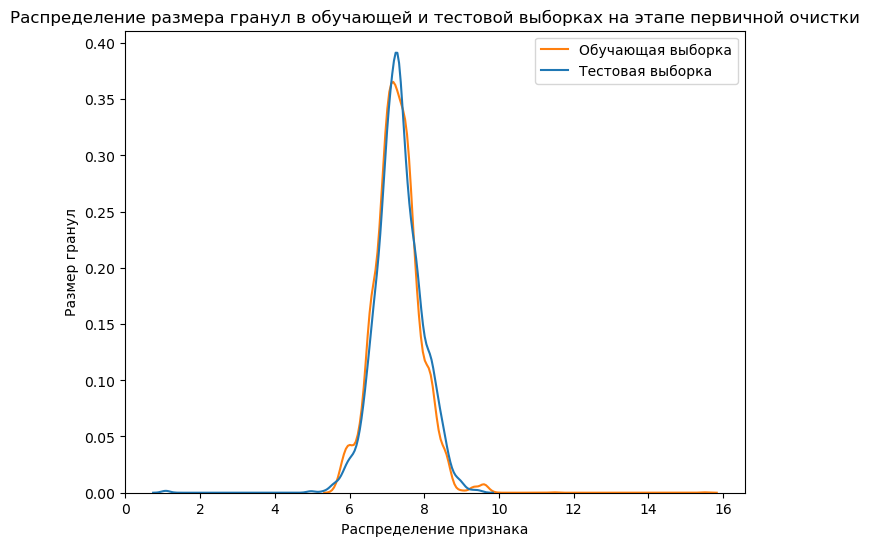

In [169]:
fig = plt.subplots(figsize=(8, 6))
sns.kdeplot(data=data, x = 'primary_cleaner.input.feed_size', hue="is_data")
plt.legend(['Обучающая выборка', 'Тестовая выборка'])
plt.title('Распределение размера гранул в обучающей и тестовой выборках на этапе первичной очистки')
plt.xlabel('Распределение признака')
plt.ylabel('Размер гранул')
plt.show()

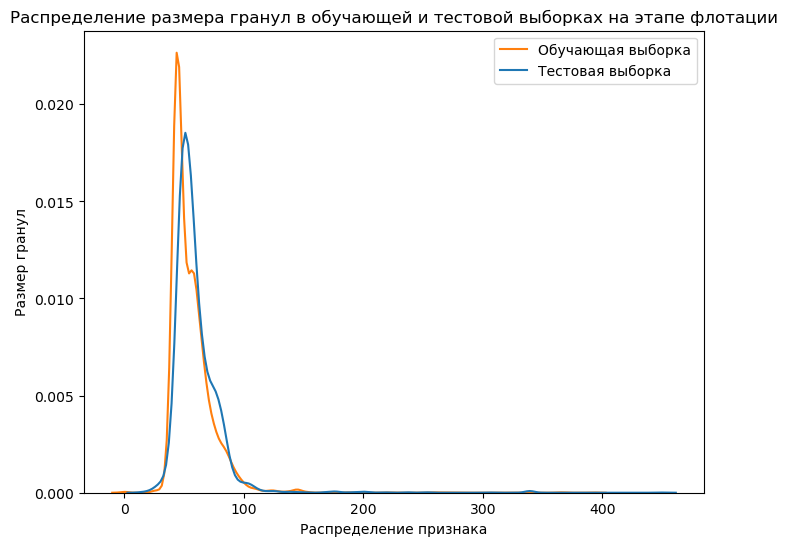

In [170]:
fig = plt.subplots(figsize=(8, 6))
sns.kdeplot(data=data, x = 'rougher.input.feed_size', hue="is_data")
plt.legend(['Обучающая выборка', 'Тестовая выборка'])
plt.title('Распределение размера гранул в обучающей и тестовой выборках на этапе флотации')
plt.xlabel('Распределение признака')
plt.ylabel('Размер гранул')
plt.show()

In [171]:
test.drop('is_data', axis = 1, inplace=True) # избавимся от столбца is_data

In [172]:
train_mod.drop('is_data', axis = 1, inplace=True)

Средние значения имеют отличия для тестовой и обучающей выборки, но они не значительны, особенно не значительны они на этапе первичной обработки, на этапе флотации различия более заметны. Однако визуально распределение средних в тестой и обучающей выборке очень похожи. Таким образом, обучающая выборка подходит для предсказаний значений эффективности на тестовой выборке.

## Cуммарная концентрация всех веществ на разных стадиях

In [173]:
final_output_concentrate = [] #создадим переменную для этапа финальной очистки
primary_cleaner_output_concentrate = [] #создадим переменную для этапа первичной очистки
rougher_output_concentrate = []  #cоздадим переменную для этапа флотации
rougher_input_feed = [] #coздадим переменную для оценки чернового сырья
cols = train.columns
for i in cols:
  if 'final.output.concentrate' in i:
    final_output_concentrate.append(i)
  elif 'primary_cleaner.output.concentrate' in i:
    primary_cleaner_output_concentrate.append(i) 
  elif 'rougher.output.concentrate' in i:
    rougher_output_concentrate.append(i) 
  elif 'rougher.input.feed' in i and not 'rate' in i and not 'size' in i:
    rougher_input_feed.append(i)

In [174]:
df = pd.DataFrame([train[final_output_concentrate].sum(axis=1), train[primary_cleaner_output_concentrate].sum(axis=1),
                   train[rougher_output_concentrate].sum(axis=1), train[rougher_input_feed].sum(axis=1)]).T
                   #cуммируем все строки и объединим все переменные в один датасет

In [175]:
df.columns = ['final_output_concentrate', 'primary_cleaner_output_concentrate', 'rougher_output_concentrate', 'rougher_input_feed']

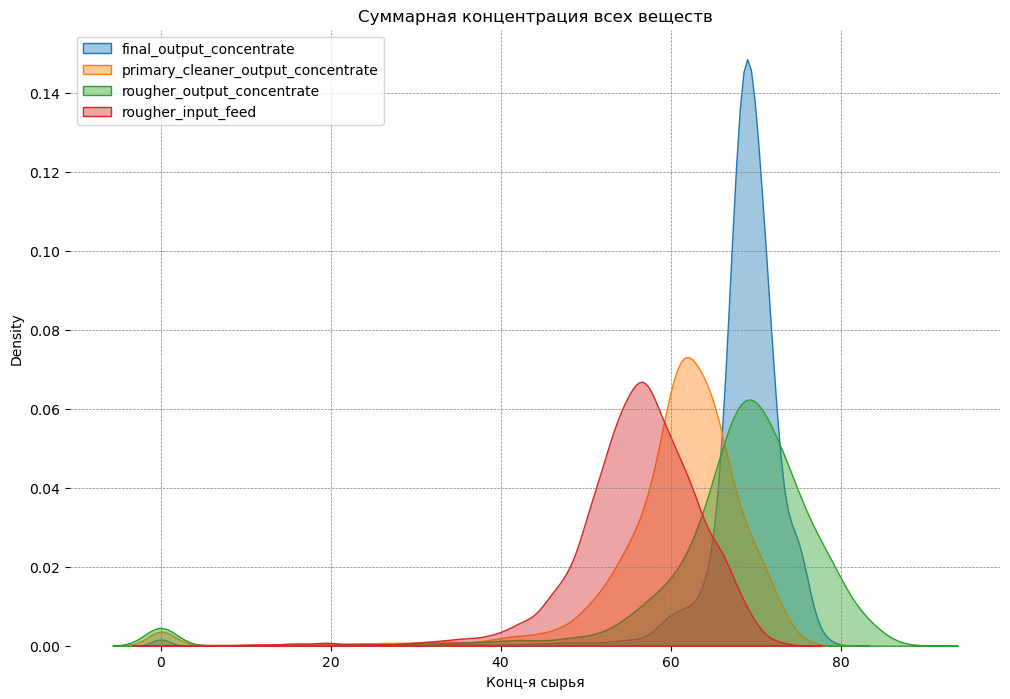

In [176]:
fig_dims = (12, 8)
fig1, ax1 = plt.subplots(figsize=fig_dims) 
for col in df.columns:        
    sns.kdeplot(df[col], shade=True, alpha=.42, ax=ax1, label = col)
    plt.title('Суммарная концентрация всех веществ', fontsize=12)
    plt.xlabel("Конц-я сырья")
    plt.grid(linewidth=0.5, color="gray", linestyle="--")
    plt.legend(loc="upper left")
    sns.despine(left=True, bottom=True)

Самая высокая концентрация всех веществ на финальной стадии очистки, что логично, продукт очищен от примесей.Чуть меньше концентрация на этапе очистки сырья после флотации, что тоже объяснимо обогощением руды. Концентрация веществ до флотации самая низкая - это руда со всеми примесями, после первичной очистки концентрация металлов и солей чуть ниже, чем на этапе после флотации, то есть часть металлов попала в отвальные хвосты (производственные потери).

Также обнаружены аномалии - нулевые значения (пустое сырье, в котором нет никаких металлов). 

## Промежуточный вывод после анализа данных

1. Мы рассмотрели, как концентрация золота и других металлов меняется на каждой стадии обогощения.

2. Убедились, что данные в тестовой и обучающей выборке распределены одинаково на примере размера гранул.

Можно сделать вывод, что на эффективность обогощения влияет не столько концентрация металлов в руде, хотя это тоже не последний фактор, сколько соблюдение технологического процесса - скорость загрузки руды, подача воздуха в установки, концентрация сопутсвующих обогощению реагентов.

# Моделирование

## Data Engineering

Прежде, чем приступить к посторению модели, необходимо провести некоторые манипуляции с данными:

Отфильтровать нулевые значения в таких столбцах как эффективность обогощения, концентрация золота и серебра, а также скорость подачи сырья.

In [177]:
filter_features = ['final.output.recovery', 'rougher.output.recovery','rougher.input.feed_ag', 
                         'rougher.input.feed_au', 'rougher.input.feed_rate']
#создадим список для признаков, которые будем фильтровать

In [178]:
def filters(dataframe, columns, lower_quantile): #создадим функцию, которая будем фильтровать необходимые данные
    for column in columns:
        lower_bound = dataframe[column].quantile(lower_quantile)
        dataframe = dataframe[(dataframe[column] > lower_bound)] 
    return dataframe

In [179]:
filtered_train = filters(train_mod, filter_features, 0.01)

In [180]:
print('Отфильтровано данных -', round(1-len(filtered_train)/len(train_mod), 4)*100,'%')

Отфильтровано данных - 5.99 %


In [181]:
filtered_train[filter_features].describe()

,final.output.recovery,rougher.output.recovery,rougher.input.feed_ag,rougher.input.feed_au,rougher.input.feed_rate
count,13301.000000,13301.000000,13301.000000,13301.000000,13301.000000
mean,67.226943,84.724667,8.641825,7.953162,479.228180
std,8.371506,7.468642,1.841130,1.798470,94.698016
min,32.414572,9.826876,5.446254,3.801625,175.443272
25%,62.977787,80.504348,7.163235,6.655613,429.117557
50%,67.602271,85.571926,8.208920,7.684622,499.687375
75%,72.456871,90.307447,9.966536,9.099986,547.583999
max,100.000000,99.979041,14.596026,13.126043,717.508837


## Данные для алгоритмов обучения

<div class="alert alert-info"> Комментарий: здесь внесены основные изменения, повлиявшие на дальнейшую структуру проекта, признаки разделены на rougher и final </div> 

In [182]:
pipeline_data = make_pipeline(IterativeImputer(),
                         StandardScaler())

Так как для предсказания эффективности обогощения чернового сырья результаты первичной и вторичной очистки продукта не нужны, выделим только те признаки, которые отвечают за флотацию. Для финального обогощения наоборот признаки, отвечающие за флотацию, не важны, а вот первичная и вторичная очистка имеют непосредственное влияние. 

In [183]:
columns_rougher = ['final.output.recovery', 'rougher.output.recovery', 'primary_cleaner.input.sulfate',
                   'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
                   'primary_cleaner.input.xanthate', 'primary_cleaner.state.floatbank8_a_air',
                   'primary_cleaner.state.floatbank8_a_level', 'primary_cleaner.state.floatbank8_b_air',
                  'primary_cleaner.state.floatbank8_b_level','primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level', 'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'secondary_cleaner.state.floatbank2_a_air',
       'secondary_cleaner.state.floatbank2_a_level','secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank2_b_level','secondary_cleaner.state.floatbank3_a_air',
       'secondary_cleaner.state.floatbank3_a_level','secondary_cleaner.state.floatbank3_b_air',
       'secondary_cleaner.state.floatbank3_b_level', 'secondary_cleaner.state.floatbank4_a_air',
       'secondary_cleaner.state.floatbank4_a_level','secondary_cleaner.state.floatbank4_b_air','secondary_cleaner.state.floatbank4_b_level',
       'secondary_cleaner.state.floatbank5_a_air','secondary_cleaner.state.floatbank5_a_level', 'secondary_cleaner.state.floatbank5_b_air',
       'secondary_cleaner.state.floatbank5_b_level','secondary_cleaner.state.floatbank6_a_air','secondary_cleaner.state.floatbank6_a_level' ]

In [184]:
columns_final =['final.output.recovery', 'rougher.output.recovery', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.output.recovery',
       'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level',
       'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level',
       'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level',
       'rougher.state.floatbank10_d_air', 'rougher.state.floatbank10_d_level',
       'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_e_level',
       'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_f_level']

In [185]:
X_train_rougher = filtered_train.drop(columns=columns_rougher, axis=1) #признаки для построения модели
X_train_final = filtered_train.drop(columns=columns_final, axis=1)
y_train_rougher = filtered_train['rougher.output.recovery'] #целеввые переменные
y_train_final = filtered_train['final.output.recovery']

In [186]:
X_train_rougher.shape

(13301, 22)

In [187]:
X_train_final.shape

(13301, 30)

In [188]:
y_train_rougher.shape

(13301,)

In [189]:
y_train_final.shape

(13301,)

## Функция для вычисления итоговой sMAPE.

Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

In [190]:
def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    total = 0
    for i in range(len(y_true)):
        total += abs(y_true[i] - y_pred[i]) / ((abs(y_true[i]) + abs(y_pred[i]))/2)
        smape = abs(total*100 / len(y_true))
    return abs(smape)

In [191]:
scorer = make_scorer(smape, greater_is_better=False)

In [192]:
def smape_final(smape_rougher, smape_final):
    smape_final = (0.25 * smape_rougher + 0.75 * smape_final)
    return smape_final

## Поиск лучшей модели

In [193]:
model_selection = [] #создаем список-счетчик для дальнейшего перебора в нем параметров модели

model_selection.append(('Linear Regression' ,
                  (make_pipeline(pipeline_data, LinearRegression())))) #модель линейной регрессии
model_selection.append(('Random Forest Regressor' ,
                  (make_pipeline(pipeline_data,RandomForestRegressor(random_state=42))))) #случайный лес
model_selection.append(('KNeighbors Regressor' ,
                  (make_pipeline(pipeline_data, KNeighborsRegressor())))) #Регрессия ближайших соседей
model_selection.append(('Support Vector Regressor' ,
                  (make_pipeline(pipeline_data, SVR())))) #регрессия опорных векторов
model_name = [] #здесь будут собраны названия моделей
results = [] #cредние оценки моделей 
for pipe, model in model_selection: #цикл для кросс-валидации
    crossv_results_rougher = - cross_val_score(model , X_train_rougher, y_train_rougher, cv = 5 , scoring=scorer)
    crossv_results_final = - cross_val_score(model , X_train_final, y_train_final, cv = 5 , scoring=scorer)
    results.append(smape_final(crossv_results_rougher, crossv_results_final).mean())
    model_name.append(pipe)
df = pd.DataFrame({'Модель': model_name, 'Средняя оценка': results}) #формируем таблицу с результатами
df

,Модель,Средняя оценка
0,Linear Regression,8.282310
1,Random Forest Regressor,10.019127
2,KNeighbors Regressor,9.660876
3,Support Vector Regressor,8.101050


**Краткий вывод** 

Лучшей моделью оказалась регрессия опорных векторов. Попробуем оптимизировать ее и посмотрим результат на тестовой выборке. 

# Лучшая модель 

## Оптимизация модели для расчета эффективности обогощения чернового концентрата

Для оптимизации используем такой инструмент как optuna.

In [194]:
def objective(trial):
    C = trial.suggest_loguniform("C", 1e-5, 1e5)
    gamma = trial.suggest_loguniform("gamma", 1e-5, 1e5)
    epsilon = trial.suggest_uniform("epsilon", 0, 1)

    model = make_pipeline(pipeline_data, SVR(C=C, gamma=gamma, epsilon=epsilon))
    
    return -1.0 * np.mean(cross_val_score(model, X_train_rougher, y_train_rougher, cv=5, scoring=scorer))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)

print("Best trial:")
trial_r = study.best_trial
print("  Value: ", trial_r.value)
print("  Params: ")
for key, value in trial_r.params.items():
    print("    {}: {}".format(key, value))

[I 2023-02-12 00:16:15,083] A new study created in memory with name: no-name-f4ee143a-6ee8-4b04-9542-f205f91e122b
[I 2023-02-12 00:17:57,423] Trial 0 finished with value: 7.194108212834138 and parameters: {'C': 165.708974604863, 'gamma': 0.003988419076191686, 'epsilon': 0.6774814890887969}. Best is trial 0 with value: 7.194108212834138.
[I 2023-02-12 00:19:20,789] Trial 1 finished with value: 7.38852421980553 and parameters: {'C': 0.00031055731626867703, 'gamma': 0.056188619101949375, 'epsilon': 0.8471459308214596}. Best is trial 0 with value: 7.194108212834138.
[I 2023-02-12 00:21:52,110] Trial 2 finished with value: 7.021221254976166 and parameters: {'C': 26.67467874260133, 'gamma': 0.4321728317524477, 'epsilon': 0.12344588280343927}. Best is trial 2 with value: 7.021221254976166.
[I 2023-02-12 00:23:13,464] Trial 3 finished with value: 7.491577605987855 and parameters: {'C': 0.0002658489618722688, 'gamma': 2342.3103490952776, 'epsilon': 0.6441695055035368}. Best is trial 2 with valu

Best trial:
  Value:  7.021221254976166
  Params: 
    C: 26.67467874260133
    gamma: 0.4321728317524477
    epsilon: 0.12344588280343927


In [195]:
best_params_r = trial_r.params 

In [197]:
def objective(trial):
    C = trial.suggest_loguniform("C", 1e-5, 1e5)
    gamma = trial.suggest_loguniform("gamma", 1e-5, 1e5)
    epsilon = trial.suggest_uniform("epsilon", 0, 1)

    model = make_pipeline(pipeline_data, SVR(C=C, gamma=gamma, epsilon=epsilon))
    
    return -1.0 * np.mean(cross_val_score(model, X_train_final, y_train_final, cv=5, scoring=scorer))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)

print("Best trial:")
trial_f = study.best_trial
print("  Value: ", trial_f.value)
print("  Params: ")
for key, value in trial_f.params.items():
    print("    {}: {}".format(key, value))

[I 2023-02-12 00:42:15,056] A new study created in memory with name: no-name-984bc250-a8fe-49b0-9b67-3237b7be3a89
[I 2023-02-12 00:44:39,344] Trial 0 finished with value: 11.796425699937974 and parameters: {'C': 60957.208160522576, 'gamma': 9.581582842193389e-05, 'epsilon': 0.34423514885321405}. Best is trial 0 with value: 11.796425699937974.
[I 2023-02-12 00:46:25,489] Trial 1 finished with value: 9.604859125912842 and parameters: {'C': 0.11215261669756485, 'gamma': 7941.37690220049, 'epsilon': 0.16382409612072557}. Best is trial 1 with value: 9.604859125912842.
[I 2023-02-12 00:47:49,342] Trial 2 finished with value: 8.558771629721736 and parameters: {'C': 0.05756763127884315, 'gamma': 0.029119609956031505, 'epsilon': 0.7305372071298437}. Best is trial 2 with value: 8.558771629721736.
[I 2023-02-12 00:56:28,069] Trial 3 finished with value: 10.101067745048756 and parameters: {'C': 1068.3503324543954, 'gamma': 0.8671195847847651, 'epsilon': 0.8128558039739087}. Best is trial 2 with va

Best trial:
  Value:  8.558771629721736
  Params: 
    C: 0.05756763127884315
    gamma: 0.029119609956031505
    epsilon: 0.7305372071298437


In [201]:
best_params_f = trial_f.params 

## Тестирование модели

In [202]:
X_test_rougher = test.drop(columns=columns_rougher, axis=1) 
X_test_final =  test.drop(columns=columns_final, axis=1)
y_test_rougher = test['rougher.output.recovery'].copy() 
y_test_final = test['final.output.recovery'].copy()

In [203]:
X_test_rougher.shape

(5290, 22)

In [204]:
X_test_final.shape

(5290, 30)

In [205]:
y_test_rougher.shape

(5290,)

In [206]:
y_test_final.shape

(5290,)

In [207]:
model_best_for_rougher = make_pipeline(pipeline_data, SVR(C=best_params_r["C"], 
                                                          gamma=best_params_r["gamma"], 
                                                          epsilon=best_params_r["epsilon"])) #модель для предсказания эффективности обогощения
                                               #чернового концентрата

In [208]:
model_best_for_final = make_pipeline(pipeline_data, SVR(C=best_params_f["C"], 
                                                          gamma=best_params_f["gamma"], 
                                                          epsilon=best_params_f["epsilon"])) #модель для предсказания эффективности обогощения
                                               #финального концентрата

Обучаем модели и делаем предсказание для тестовых данных:

In [209]:
X_train_rougher.shape

(13301, 22)

In [210]:
model_best_for_rougher.fit(X_train_rougher, y_train_rougher)
y_pred_test_rougher = model_best_for_rougher.predict(X_test_rougher) 

In [211]:
smape_rougher_test = smape(y_test_rougher, y_pred_test_rougher)

In [212]:
model_best_for_final.fit(X_train_final, y_train_final)
y_pred_test_final = model_best_for_final.predict(X_test_final) 

In [213]:
smape_final_test = smape(y_test_final, y_pred_test_final)

In [214]:
smape_test = smape_final(smape_rougher_test, smape_final_test)
smape_test

8.887393377641686

## Константная модель

In [215]:
def dummy(X_train, y_train, X_test, y_test):
  dummy = DummyRegressor(strategy="mean")
  dummy.fit(X_train, y_train)
  y_pred = dummy.predict(X_test)
  smape_const = smape(y_test, y_pred)
  return smape_const

In [216]:
smape_const_rougher = dummy(X_train_rougher, y_train_rougher, X_test_rougher, y_test_rougher)

In [217]:
smape_const_final = dummy(X_train_final, y_train_final, X_test_final, y_test_final)

In [218]:
smape_const = smape_final(smape_const_rougher, smape_const_final)

In [219]:
smape_const

9.63181163405932

In [220]:
if smape_const > smape_test:
  print('оценка тестовой модели лучше, чем константной, следовательно внедрение тестовой модели обосновано')
if smape_const < smape_test:
  print('оценка константной модели лучше, внедрение модели не обосновано')

оценка тестовой модели лучше, чем константной, следовательно внедрение тестовой модели обосновано


### Средняя ошибка

In [221]:
df_pred = pd.DataFrame({'rougher.output.recovery_pred': y_pred_test_rougher, 'final.output.recovery_pred': y_pred_test_final})
#coздадим новый датафрейм для предсказанных значений

In [222]:
test = test.reset_index()

In [223]:
test_error = pd.concat([test, df_pred], axis=1, ignore_index=False) #соединим предсказнные и полученные на производстве признаки эффективности

In [224]:
test_error.shape

(5290, 57)

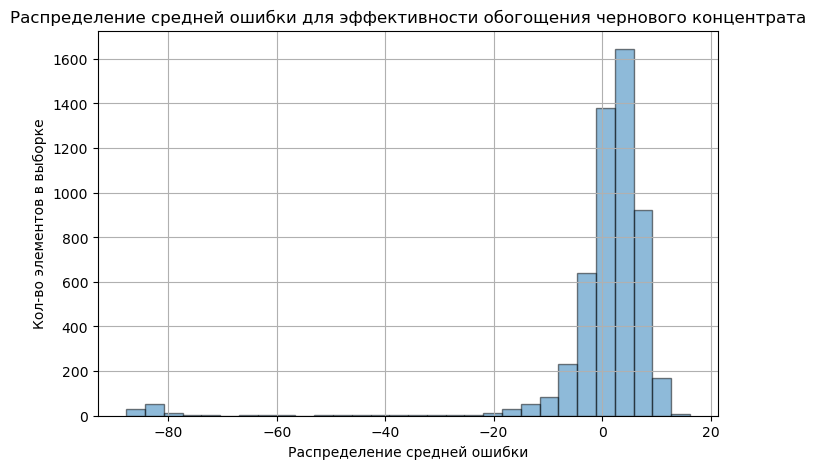

In [225]:
test_error['rougher_error'] = test_error['rougher.output.recovery']-test_error['rougher.output.recovery_pred']
test_error['rougher_error'].hist(bins = 30, grid=True, alpha=0.5, edgecolor='black', figsize=(8,5))
plt.title('Распределение средней ошибки для эффективности обогощения чернового концентрата')
plt.xlabel('Распределение средней ошибки')
plt.ylabel('Кол-во элементов в выборке')
plt.show()

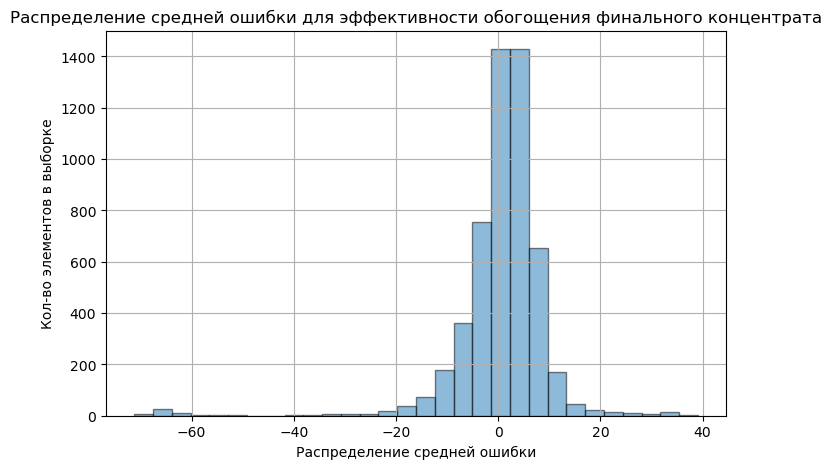

In [226]:
test_error['final_error'] = test_error['final.output.recovery']-test_error['final.output.recovery_pred']
test_error['final_error'].hist(bins = 30, grid=True, alpha=0.5, edgecolor='black', figsize=(8,5))
plt.title('Распределение средней ошибки для эффективности обогощения финального концентрата')
plt.xlabel('Распределение средней ошибки')
plt.ylabel('Кол-во элементов в выборке')
plt.show()

In [227]:
print('Cредняя ошибка для предсказания эффективности обогощения чернового конц-та',
      test_error['rougher_error'].mean())
print('Cредняя ошибка для предсказания эффективности обогощения финального конц-та',
      test_error['final_error'].mean())

Cредняя ошибка для предсказания эффективности обогощения чернового конц-та 0.33778150335340684
Cредняя ошибка для предсказания эффективности обогощения финального конц-та 0.6487176933370848


Очень сильный разброс ошибок, в предсказаниях для эффективности обогощения чернового концентрата есть ошибки свыше 80%, у эффективности обогощния встречаются ошибки чуть меньше, но близкие к 80%. В среднем ошибка составила от -1% до 1%.

### Абсолютная ошибка 

In [228]:
def ads_error(row): 
  if row < 0:
    return row*(-1)
  else:
    return row

In [229]:
test_error['rougher_error_abs'] = test_error['rougher_error'].apply(ads_error) #cоздадим новые признаки для абсолютной ошибки
test_error['final_error_abs'] = test_error['final_error'].apply(ads_error)

In [230]:
test_error['rougher_error_abs'].describe() 

count    5290.000000
mean        5.860134
std        11.401562
min         0.002618
25%         1.823911
50%         3.810283
75%         6.249656
max        87.735983
Name: rougher_error_abs, dtype: float64

In [231]:
test_error['final_error_abs'].describe()

count    5290.000000
mean        5.430148
std         7.310631
min         0.000854
25%         1.805646
50%         3.806730
75%         6.574657
max        71.229973
Name: final_error_abs, dtype: float64

In [232]:
def print_error (col, name):
    test_error['group'] = pd.cut(test_error[col], bins=[0., 40.0, 65.0, 75.0, 80.0, np.inf]) 
    s = test_error.groupby('group')[[f'{name}_error_abs', f'{name}_error']].agg(['count','mean']) 
    s.columns = ['_'.join(col) for col in s.columns.values]
    s = s.drop(f'{name}_error_count', axis=1)
    s['mean_error_diff'] = s[f'{name}_error_abs_mean']-test_error[f'{name}_error_abs'].mean() 
    s['mean'] = test_error[f'{name}_error_abs'].mean() 
    display(s.style.background_gradient(cmap=cm, subset=['mean_error_diff']))

In [233]:
print_error('rougher.output.recovery', 'rougher')

,rougher_error_abs_count,rougher_error_abs_mean,rougher_error_mean,mean_error_diff,mean
group,,,,,
"(0.0, 40.0]",12,57.917736,-57.917736,52.057602,5.860134
"(40.0, 65.0]",33,24.061201,-24.061201,18.201067,5.860134
"(65.0, 75.0]",128,11.202895,-11.202895,5.342761,5.860134
"(75.0, 80.0]",285,5.222297,-5.115501,-0.637837,5.860134
"(80.0, inf]",4735,3.910732,3.007228,-1.949402,5.860134


In [234]:
print_error('final.output.recovery', 'final')

,final_error_abs_count,final_error_abs_mean,final_error_mean,mean_error_diff,mean
group,,,,,
"(0.0, 40.0]",23,39.149541,-39.149541,33.719393,5.430148
"(40.0, 65.0]",1140,6.620859,-6.528373,1.190711,5.430148
"(65.0, 75.0]",3313,3.055405,2.079175,-2.374743,5.430148
"(75.0, 80.0]",629,7.588857,7.588857,2.158709,5.430148
"(80.0, inf]",145,18.945236,18.945236,13.515088,5.430148


- Эффективность обогощения чернового концентрата имеет более сильный разброс в предсказаниях. Модель хорошо может предсказать эффективность обогощения начиная от 65%, низкую эффективность обогощения черновой руды модель предсказывает крайне плохо, от чего и высокая средняя ошибка.
- С финальной эффективностью модель справилась чуть лучше, но опять же нестандартную эффективность ниже 40% или выше 80% модель предсказать не может.

Для дальнейшего использования модели очень важно знать, есть ли в данных ошибки, которые включают в себя нулевые значения, или все же это не ошибки а реальные показатеи с производства, когда вместе с зотоносной рудой может происходить обогощение пустых пород.

# Общий вывод

Проведена исследовательская работа по обогощению золотоносной руды. В ходе исследования были изучены производственные процессы флотации и последующей обработки руды. Было выявлено, что эффективность обогощения расчитывается от доли металла полученного в результате обогощения и доли металла в отвальных хвостах. На сам процесс обогощения и улучшения его эффективности влияют такие факторы как содержание ценных металлов в руде, скорость подачи руды, объем воздуха в установках и концентрация сульфатов и ксантогенатов. 

Далее процесс обогощения был смоделирован с помощью моделей: Линейной регрессии, Случайного леса, Регрессии ближайших соседей и Регрессии опорных векторов, в результате была выбрана модель SVR для которой расчитана метрика sMAPE. На тестовой выборке она показала ошибку - 9,3%, ошибка константной модели при этом - 9,6%.

К сожалению при анализе ошибок модели было выявлено, что модель может предсказывать только стандартную эффективность, эффективность ниже 40% она предсказать не смогла. Возможно требуется дороботка тестовых данных, например включить в выборку концентрацию металла в хвостах.